# Experimento de Ablacion
Dataset: MERDWild

In [1]:
import os  
from glob import glob  
import numpy as np 
import pandas as pd
from IPython.display import Audio 
from scipy.special import softmax 
import cv2
from skimage.color import rgb2gray
import matplotlib.pyplot as plt  
from matplotlib import colormaps  
from matplotlib.colors import Normalize
from tqdm import tqdm  
import pickle 
from skimage.io import imread 
from skimage.util import img_as_float32, random_noise 
from skimage.transform import resize_local_mean, rotate 
from skimage.color import gray2rgb 
import librosa 
from sklearn.neural_network import MLPClassifier 
from functools import reduce 
from sklearn import metrics 
import torch 
from torch import nn 
from torch.optim import Adam 
from torch.autograd import Variable  
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader  
from torchvision.models import resnet50
from sentence_transformers import SentenceTransformer  
from transformers import BertModel, BertConfig, TransfoXLModel, XLNetModel 
import warnings 

## Obtencion de Features
Tenemos que obtener las features de los datos de entrenamiento y validacion. De modo de tener todos los ejemplos para cada uterancia de emoción.
Idealmente, tendriamos que identificar desde los archivos de datos de AffWild, identificar las uterancias, de modo de tener el evento exacto para obtener las features por arquitectura.

In [2]:
labelnames = ['Neutral', 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']
labeldict = {label: i for i, label in enumerate(labelnames)}

### Creacion de Dataset

In [3]:
# def open_MERDWild_image_df(path, root=""):
#     df_0 = pd.read_csv(path, sep=',', index_col='Index')
#     df = df_0[df_0['Image_Filter'] == 1].copy()  # Usar solo imágenes de buena calidad
#     df['Filepath'] = root_path + "\\" + df['KEY']
#     existing_files = [os.path.join(root, impath) for impath in df['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]
#     df = df[df['Filepath'].isin(existing_files)]
# #     percentage = 0.30
# #     # Utiliza el método 'sample' para obtener una muestra aleatoria del 30%
# #     df = df.sample(frac=percentage, random_state=42)    
#     return df

def open_MERDWild_image_df(path, root=""):
    df_0 = pd.read_csv(path, sep=',')
    df = df_0[df_0['Image_Filter'] == 1].copy()
    df['Filepath'] = root_path + "\\" + df['KEY']
    df.reset_index(drop=True, inplace=True)
    df.index.name = 'Index'
    existing_files = [os.path.join(root, impath) for impath in df['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]
    df = df[df['Filepath'].isin(existing_files)]
    #     percentage = 0.30
    #     # Utiliza el método 'sample' para obtener una muestra aleatoria del 30%
    #     df = df.sample(frac=percentage, random_state=42)    
    return df


def open_MERDWild_audio_df(path, root=""):
    df_0 = pd.read_csv(path, sep=',')
    #df = df_0[df_0['Audio_Filter'] == 1].copy() 
    df_0['Filepath'] = root_path + "\\" + df_0['KEY']
    df_0.reset_index(drop=True, inplace=True)
    df_0.index.name = 'Index'
    existing_files = [os.path.join(root, impath) for impath in df_0['Filepath'].tolist() if os.path.exists(os.path.join(root, impath))]
    df_0 = df_0[df_0['Filepath'].isin(existing_files)]
#     percentage = 0.30
#     # Utiliza el método 'sample' para obtener una muestra aleatoria del 30%
#     df = df.sample(frac=percentage, random_state=42)    
    return df_0

## Cambiar ruta de BD

In [4]:
root_path = r"D:\Datasets\MERDWild"

#### No modificar

In [5]:
import os
save_pickle = root_path + "\\" + r"trained_models\faces" 

if not os.path.exists(save_pickle):
    os.makedirs(save_pickle)
    print(f"La carpeta '{save_pickle}' ha sido creada.")
else:
    print(f"La carpeta '{save_pickle}' ya existe.")

La carpeta 'D:\Datasets\MERDWild\trained_models\faces' ya existe.


In [6]:
train_audio_file = root_path + "\\" + r"Training\Calidad_Audios_Unificados_TRAIN.csv"
valid_audio_file = root_path + "\\" + r"Validation\Calidad_Audios_Unificados_VAL.csv"

train_face_file = root_path + "\\" + r"Training\Calidad_Imagenes_Unificadas_TRAIN.csv"
valid_face_file = root_path + "\\" + r"Validation\Calidad_Imagenes_Unificadas_VAL.csv"

# train_audio_file = root_path + "\\" + r"Test\audios_train.csv"
# valid_audio_file = root_path + "\\" + r"Test\audios_valid.csv"

# train_face_file = root_path + "\\" + r"Test\imagenes_train.csv"
# valid_face_file = root_path + "\\" + r"Test\imagenes_valid.csv"

train_csv = root_path + "\\" + r"trainembrace.csv"
val_csv = root_path + "\\" + r"validembrace.csv"

solo_img_pth = save_pickle + "\\" + r"Face_MERDWild.pth"
solo_audios_pth = save_pickle + "\\" + r"MERDWild_audio.pth"

valid_text = save_pickle + "\\" + "valid_text_feats.pkl"
train_text = save_pickle + "\\" + "train_text_feats.pkl"

valid_audios = save_pickle + "\\" + r"valid_audio_feats.pkl"
train_audios = save_pickle + "\\" + r"train_audio_feats.pkl"

valid_img = save_pickle + "\\" + r"valid_image_feats.pkl"
train_img = save_pickle + "\\" + r"train_image_feats.pkl"

train_audio = open_MERDWild_audio_df(train_audio_file)
valid_audio = open_MERDWild_audio_df(valid_audio_file)

trainface = open_MERDWild_image_df(train_face_file)
validface = open_MERDWild_image_df(valid_face_file)

traindf = pd.DataFrame(columns=["filename", "impath", "AudioDuration", "label", "ilabel", "Text"])
validdf = pd.DataFrame(columns=["filename", "impath", "AudioDuration", "label", "ilabel", "Text"])

print(f"Para audios: Entrenamiento {len(train_audio)}, y validacion {len(valid_audio)}")
print(f"Para caras: Entrenamiento {len(trainface)}, y validacion {len(validface)}")

C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2426225968.py:20: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_0 = pd.read_csv(path, sep=',')


Para audios: Entrenamiento 13799, y validacion 2442
Para caras: Entrenamiento 702043, y validacion 203238


In [7]:
train_audio.head()

,Unnamed: 0,Index,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,...,Tokens,Semantic_Filter,Text_Filter,Source_DB,Set,Fila,Lemmatized_Tokens,Emotion,KEY,Filepath
Index,,,,,,,,,,,,,,,,,,,,,
0,0,0,1-30-1280x720_1.wav,5.0,-21.327148,-6.677271,31.132925,-24.404155,1,0,...,"['waiting', 'half', 'like', 'let', 'us', 'begin']",0.110472,1,AffWild2,train,1,"['wait', 'half', 'like', 'let', 'we', 'begin']",Happy,Training\Audios\1-30-1280x720_1.wav,D:\Datasets\MERDWild\Training\Audios\1-30-1280...
1,1,1,1-30-1280x720_11.wav,5.0,-22.338631,-8.920077,32.734259,-7.987095,1,0,...,"['imagine', 'floating', 'like', 'bird', 'flyin...",0.074816,1,AffWild2,train,2,"['imagine', 'float', 'like', 'bird', 'fly', 's...",Neutral,Training\Audios\1-30-1280x720_11.wav,D:\Datasets\MERDWild\Training\Audios\1-30-1280...
2,2,2,1-30-1280x720_13.wav,5.0,-21.901210,-7.658042,31.550654,-8.585075,1,0,...,"['floating', 'like', 'bird', 'flying', 'sky', ...",0.076046,1,AffWild2,train,3,"['float', 'like', 'bird', 'fly', 'sky', 'breat...",Neutral,Training\Audios\1-30-1280x720_13.wav,D:\Datasets\MERDWild\Training\Audios\1-30-1280...
3,3,3,1-30-1280x720_15.wav,5.0,-23.111508,-7.487532,30.130167,-9.756408,1,0,...,"['sky', 'brazen', 'amber']",0.154469,1,AffWild2,train,4,"['sky', 'brazen', 'amber']",Neutral,Training\Audios\1-30-1280x720_15.wav,D:\Datasets\MERDWild\Training\Audios\1-30-1280...
4,4,4,1-30-1280x720_17.wav,5.0,-22.912567,-7.487532,30.335233,-9.642979,1,0,...,"['bruin', 'embryoed']",0.202369,1,AffWild2,train,5,"['bruin', 'embryoe']",Neutral,Training\Audios\1-30-1280x720_17.wav,D:\Datasets\MERDWild\Training\Audios\1-30-1280...


In [8]:
train_audio.columns

Index(['Unnamed: 0', 'Index', 'File_Name_Ext', 'Duration',
       'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion',
       'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Semantic_Filter', 'Text_Filter', 'Source_DB', 'Set', 'Fila',
       'Lemmatized_Tokens', 'Emotion', 'KEY', 'Filepath'],
      dtype='object')

In [9]:
df_text = train_audio.loc[train_audio['Text_Filter'] == 1, ['KEY', 'Emotion', 'Text_Filter', 'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens', 'Filepath']].copy()
df_audio = train_audio.loc[train_audio['Audio_Filter'] == 1, ['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter']].copy()

df_text

,KEY,Emotion,Text_Filter,Transcription,Lowercase_Transcription,Text_Without_Stopwords,Tokens,Semantic_Filter,Source_DB,Set,Lemmatized_Tokens,Filepath
Index,,,,,,,,,,,,
0,Training\Audios\1-30-1280x720_1.wav,Happy,1,YOU'VE BEEN WAITING HALF LIKE THAT AND LET'S B...,you have been waiting half like that and let u...,waiting half like let us begin,"['waiting', 'half', 'like', 'let', 'us', 'begin']",0.110472,AffWild2,train,"['wait', 'half', 'like', 'let', 'we', 'begin']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
1,Training\Audios\1-30-1280x720_11.wav,Neutral,1,IMAGINE YOU'RE FLOATING LIKE A BIRD FLYING IN ...,imagine you are floating like a bird flying in...,imagine floating like bird flying sky,"['imagine', 'floating', 'like', 'bird', 'flyin...",0.074816,AffWild2,train,"['imagine', 'float', 'like', 'bird', 'fly', 's...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
2,Training\Audios\1-30-1280x720_13.wav,Neutral,1,FLOATING LIKE A BIRD FLYING IN THE SKY BREATHING,floating like a bird flying in the sky breathing,floating like bird flying sky breathing,"['floating', 'like', 'bird', 'flying', 'sky', ...",0.076046,AffWild2,train,"['float', 'like', 'bird', 'fly', 'sky', 'breat...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
3,Training\Audios\1-30-1280x720_15.wav,Neutral,1,IN THE SKY BRAZEN AMBER,in the sky brazen amber,sky brazen amber,"['sky', 'brazen', 'amber']",0.154469,AffWild2,train,"['sky', 'brazen', 'amber']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
4,Training\Audios\1-30-1280x720_17.wav,Neutral,1,BRUIN EMBRYOED,bruin embryoed,bruin embryoed,"['bruin', 'embryoed']",0.202369,AffWild2,train,"['bruin', 'embryoe']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
...,...,...,...,...,...,...,...,...,...,...,...,...
13793,Training\Audios\020127800.wav,Neutral,1,AND I WAS WONDERING WHAT DUMA WOULD MAKE OF AL...,and i was wondering what duma would make of al...,wondering duma would make,"['wondering', 'duma', 'would', 'make']",0.135164,AFEW,train,"['wonder', 'duma', 'would', 'make']",D:\Datasets\MERDWild\Training\Audios\020127800...
13794,Training\Audios\020913240.wav,Angry,1,I'M DONE YOUNG MAN,i am done young man,done young man,"['done', 'young', 'man']",0.112855,AFEW,train,"['do', 'young', 'man']",D:\Datasets\MERDWild\Training\Audios\020913240...
13795,Training\Audios\020950800.wav,Neutral,1,WE WON'T KILL HIM,we will not kill him,kill,['kill'],0.148520,AFEW,train,['kill'],D:\Datasets\MERDWild\Training\Audios\020950800...


In [16]:
df_audio

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,Audio_Filter
Index,,,,,,,,,,,
0,Training\Audios\1-30-1280x720_1.wav,Happy,1-30-1280x720_1.wav,5.000,-21.327148,-6.677271,31.132925,-24.404155,1,0,1
1,Training\Audios\1-30-1280x720_11.wav,Neutral,1-30-1280x720_11.wav,5.000,-22.338631,-8.920077,32.734259,-7.987095,1,0,1
2,Training\Audios\1-30-1280x720_13.wav,Neutral,1-30-1280x720_13.wav,5.000,-21.901210,-7.658042,31.550654,-8.585075,1,0,1
3,Training\Audios\1-30-1280x720_15.wav,Neutral,1-30-1280x720_15.wav,5.000,-23.111508,-7.487532,30.130167,-9.756408,1,0,1
4,Training\Audios\1-30-1280x720_17.wav,Neutral,1-30-1280x720_17.wav,5.000,-22.912567,-7.487532,30.335233,-9.642979,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
13793,Training\Audios\020127800.wav,Neutral,020127800.wav,3.456,-40.245733,-24.747652,36.198505,-3.944512,1,0,1
13794,Training\Audios\020913240.wav,Angry,020913240.wav,1.704,-29.122432,-12.487174,32.044442,-3.638610,1,0,1
13795,Training\Audios\020950800.wav,Neutral,020950800.wav,1.344,-33.931380,-21.814632,35.466512,-3.944226,1,0,1


In [17]:
train_audio = pd.merge(df_audio, df_text, left_on=['KEY', 'Emotion'], right_on=['KEY', 'Emotion'], how='outer')
train_audio

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,...,Text_Filter,Transcription,Lowercase_Transcription,Text_Without_Stopwords,Tokens,Semantic_Filter,Source_DB,Set,Lemmatized_Tokens,Filepath
0,Training\Audios\1-30-1280x720_1.wav,Happy,1-30-1280x720_1.wav,5.000,-21.327148,-6.677271,31.132925,-24.404155,1,0,...,1.0,YOU'VE BEEN WAITING HALF LIKE THAT AND LET'S B...,you have been waiting half like that and let u...,waiting half like let us begin,"['waiting', 'half', 'like', 'let', 'us', 'begin']",0.110472,AffWild2,train,"['wait', 'half', 'like', 'let', 'we', 'begin']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
1,Training\Audios\1-30-1280x720_11.wav,Neutral,1-30-1280x720_11.wav,5.000,-22.338631,-8.920077,32.734259,-7.987095,1,0,...,1.0,IMAGINE YOU'RE FLOATING LIKE A BIRD FLYING IN ...,imagine you are floating like a bird flying in...,imagine floating like bird flying sky,"['imagine', 'floating', 'like', 'bird', 'flyin...",0.074816,AffWild2,train,"['imagine', 'float', 'like', 'bird', 'fly', 's...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
2,Training\Audios\1-30-1280x720_13.wav,Neutral,1-30-1280x720_13.wav,5.000,-21.901210,-7.658042,31.550654,-8.585075,1,0,...,1.0,FLOATING LIKE A BIRD FLYING IN THE SKY BREATHING,floating like a bird flying in the sky breathing,floating like bird flying sky breathing,"['floating', 'like', 'bird', 'flying', 'sky', ...",0.076046,AffWild2,train,"['float', 'like', 'bird', 'fly', 'sky', 'breat...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
3,Training\Audios\1-30-1280x720_15.wav,Neutral,1-30-1280x720_15.wav,5.000,-23.111508,-7.487532,30.130167,-9.756408,1,0,...,1.0,IN THE SKY BRAZEN AMBER,in the sky brazen amber,sky brazen amber,"['sky', 'brazen', 'amber']",0.154469,AffWild2,train,"['sky', 'brazen', 'amber']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
4,Training\Audios\1-30-1280x720_17.wav,Neutral,1-30-1280x720_17.wav,5.000,-22.912567,-7.487532,30.335233,-9.642979,1,0,...,1.0,BRUIN EMBRYOED,bruin embryoed,bruin embryoed,"['bruin', 'embryoed']",0.202369,AffWild2,train,"['bruin', 'embryoe']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,Training\Audios\020127800.wav,Neutral,020127800.wav,3.456,-40.245733,-24.747652,36.198505,-3.944512,1,0,...,1.0,AND I WAS WONDERING WHAT DUMA WOULD MAKE OF AL...,and i was wondering what duma would make of al...,wondering duma would make,"['wondering', 'duma', 'would', 'make']",0.135164,AFEW,train,"['wonder', 'duma', 'would', 'make']",D:\Datasets\MERDWild\Training\Audios\020127800...
13549,Training\Audios\020913240.wav,Angry,020913240.wav,1.704,-29.122432,-12.487174,32.044442,-3.638610,1,0,...,1.0,I'M DONE YOUNG MAN,i am done young man,done young man,"['done', 'young', 'man']",0.112855,AFEW,train,"['do', 'young', 'man']",D:\Datasets\MERDWild\Training\Audios\020913240...
13550,Training\Audios\020950800.wav,Neutral,020950800.wav,1.344,-33.931380,-21.814632,35.466512,-3.944226,1,0,...,1.0,WE WON'T KILL HIM,we will not kill him,kill,['kill'],0.148520,AFEW,train,['kill'],D:\Datasets\MERDWild\Training\Audios\020950800...
13551,Training\Audios\021437680.wav,Neutral,021437680.wav,2.928,-37.310683,-19.689645,33.303286,-3.944373,1,0,...,1.0,AIN'T IT'S COMING OUT WITH ALL CARE'S WAY TO C...,am not it is coming out with all cares way to ...,coming cares way cure ways,"['coming', 'cares', 'way', 'cure', 'ways']",0.136548,AFEW,train,"['come', 'care', 'way', 'cure', 'way']",D:\Datasets\MERDWild\Training\Audios\021437680...


In [18]:
train_audio.columns

Index(['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level',
       'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio',
       'First_Filter', 'Failures', 'Audio_Filter', 'Text_Filter',
       'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords',
       'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens',
       'Filepath'],
      dtype='object')

In [19]:
train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].astype(str)

#train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].str.replace('.wav', '')

train_audio['File_Name_Ext'] = train_audio['File_Name_Ext'].str.zfill(5)
train_audio

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,...,Text_Filter,Transcription,Lowercase_Transcription,Text_Without_Stopwords,Tokens,Semantic_Filter,Source_DB,Set,Lemmatized_Tokens,Filepath
0,Training\Audios\1-30-1280x720_1.wav,Happy,1-30-1280x720_1.wav,5.000,-21.327148,-6.677271,31.132925,-24.404155,1,0,...,1.0,YOU'VE BEEN WAITING HALF LIKE THAT AND LET'S B...,you have been waiting half like that and let u...,waiting half like let us begin,"['waiting', 'half', 'like', 'let', 'us', 'begin']",0.110472,AffWild2,train,"['wait', 'half', 'like', 'let', 'we', 'begin']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
1,Training\Audios\1-30-1280x720_11.wav,Neutral,1-30-1280x720_11.wav,5.000,-22.338631,-8.920077,32.734259,-7.987095,1,0,...,1.0,IMAGINE YOU'RE FLOATING LIKE A BIRD FLYING IN ...,imagine you are floating like a bird flying in...,imagine floating like bird flying sky,"['imagine', 'floating', 'like', 'bird', 'flyin...",0.074816,AffWild2,train,"['imagine', 'float', 'like', 'bird', 'fly', 's...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
2,Training\Audios\1-30-1280x720_13.wav,Neutral,1-30-1280x720_13.wav,5.000,-21.901210,-7.658042,31.550654,-8.585075,1,0,...,1.0,FLOATING LIKE A BIRD FLYING IN THE SKY BREATHING,floating like a bird flying in the sky breathing,floating like bird flying sky breathing,"['floating', 'like', 'bird', 'flying', 'sky', ...",0.076046,AffWild2,train,"['float', 'like', 'bird', 'fly', 'sky', 'breat...",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
3,Training\Audios\1-30-1280x720_15.wav,Neutral,1-30-1280x720_15.wav,5.000,-23.111508,-7.487532,30.130167,-9.756408,1,0,...,1.0,IN THE SKY BRAZEN AMBER,in the sky brazen amber,sky brazen amber,"['sky', 'brazen', 'amber']",0.154469,AffWild2,train,"['sky', 'brazen', 'amber']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
4,Training\Audios\1-30-1280x720_17.wav,Neutral,1-30-1280x720_17.wav,5.000,-22.912567,-7.487532,30.335233,-9.642979,1,0,...,1.0,BRUIN EMBRYOED,bruin embryoed,bruin embryoed,"['bruin', 'embryoed']",0.202369,AffWild2,train,"['bruin', 'embryoe']",D:\Datasets\MERDWild\Training\Audios\1-30-1280...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,Training\Audios\020127800.wav,Neutral,020127800.wav,3.456,-40.245733,-24.747652,36.198505,-3.944512,1,0,...,1.0,AND I WAS WONDERING WHAT DUMA WOULD MAKE OF AL...,and i was wondering what duma would make of al...,wondering duma would make,"['wondering', 'duma', 'would', 'make']",0.135164,AFEW,train,"['wonder', 'duma', 'would', 'make']",D:\Datasets\MERDWild\Training\Audios\020127800...
13549,Training\Audios\020913240.wav,Angry,020913240.wav,1.704,-29.122432,-12.487174,32.044442,-3.638610,1,0,...,1.0,I'M DONE YOUNG MAN,i am done young man,done young man,"['done', 'young', 'man']",0.112855,AFEW,train,"['do', 'young', 'man']",D:\Datasets\MERDWild\Training\Audios\020913240...
13550,Training\Audios\020950800.wav,Neutral,020950800.wav,1.344,-33.931380,-21.814632,35.466512,-3.944226,1,0,...,1.0,WE WON'T KILL HIM,we will not kill him,kill,['kill'],0.148520,AFEW,train,['kill'],D:\Datasets\MERDWild\Training\Audios\020950800...
13551,Training\Audios\021437680.wav,Neutral,021437680.wav,2.928,-37.310683,-19.689645,33.303286,-3.944373,1,0,...,1.0,AIN'T IT'S COMING OUT WITH ALL CARE'S WAY TO C...,am not it is coming out with all cares way to ...,coming cares way cure ways,"['coming', 'cares', 'way', 'cure', 'ways']",0.136548,AFEW,train,"['come', 'care', 'way', 'cure', 'way']",D:\Datasets\MERDWild\Training\Audios\021437680...


In [20]:
trainface['Folder'] = trainface['Folder'].astype(str)

#trainface['File_Name_Ext'] = trainface['File_Name_Ext'].str.replace('.wav', '')

trainface['Folder'] = trainface['Folder'].str.zfill(5)
trainface

,Unnamed: 0,KEY,Ruta Completa,Similitud,Index,First_Filter,Brightness,Contrast,Entropy,Facial_Points,...,Failures,Folder,Emotion,Set,Source_DB,Image_Filter,Width,Height,File_Name_Ext,Filepath
Index,,,,,,,,,,,,,,,,,,,,,
0,0,Training\Rostros\111_2\00023.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...,0.994842,34088,1,93.902224,78.727054,5.718789,23,...,0,111_2,Disgust,train,AffWild2,1,106.0,140.0,00023.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...
1,1,Training\Rostros\111_2\00024.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...,0.990290,34089,1,93.928976,74.388018,5.737129,21,...,0,111_2,Disgust,train,AffWild2,1,106.0,140.0,00024.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...
2,2,Training\Rostros\111_2\00025.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...,0.992890,34090,1,93.324903,80.576611,5.730886,13,...,0,111_2,Disgust,train,AffWild2,1,106.0,141.0,00025.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...
3,3,Training\Rostros\111_2\00026.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...,0.983947,34091,1,93.605391,77.262645,5.741017,23,...,0,111_2,Disgust,train,AffWild2,1,106.0,140.0,00026.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...
4,4,Training\Rostros\111_2\00027.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...,0.988776,34092,1,93.250234,74.464018,5.729340,18,...,0,111_2,Disgust,train,AffWild2,1,106.0,141.0,00027.jpg,D:\Datasets\MERDWild\Training\Rostros\111_2\00...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702038,726953,Training\Rostros\dia892_utt10\result_dia892_ut...,D:\Datasets\MERDWild\Training\Rostros\dia892_u...,0.969057,792549,1,100.243205,8.531674,4.827123,12,...,0,dia892_utt10,Angry,train,MELD,1,155.0,188.0,result_dia892_utt10.218.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...
702039,726954,Training\Rostros\dia892_utt10\result_dia892_ut...,D:\Datasets\MERDWild\Training\Rostros\dia892_u...,0.988331,792550,1,109.059457,31.301602,4.951204,32,...,0,dia892_utt10,Angry,train,MELD,1,150.0,184.0,result_dia892_utt10.39.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...
702040,726955,Training\Rostros\dia892_utt10\result_dia892_ut...,D:\Datasets\MERDWild\Training\Rostros\dia892_u...,0.980927,792551,1,109.070492,28.309720,4.928203,24,...,0,dia892_utt10,Angry,train,MELD,1,150.0,183.0,result_dia892_utt10.41.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...


In [21]:
union_train_df = pd.merge(train_audio, trainface, left_on=['File_Name_Ext', 'Emotion'], right_on=['Folder', 'Emotion'], how='outer')
union_train_df

,KEY_x,Emotion,File_Name_Ext_x,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter_x,Failures_x,...,Blur,Failures_y,Folder,Set_y,Source_DB_y,Image_Filter,Width,Height,File_Name_Ext_y,Filepath_y
0,Training\Audios\1-30-1280x720_1.wav,Happy,1-30-1280x720_1.wav,5.0,-21.327148,-6.677271,31.132925,-24.404155,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Training\Audios\1-30-1280x720_11.wav,Neutral,1-30-1280x720_11.wav,5.0,-22.338631,-8.920077,32.734259,-7.987095,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Training\Audios\1-30-1280x720_13.wav,Neutral,1-30-1280x720_13.wav,5.0,-21.901210,-7.658042,31.550654,-8.585075,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Training\Audios\1-30-1280x720_15.wav,Neutral,1-30-1280x720_15.wav,5.0,-23.111508,-7.487532,30.130167,-9.756408,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Training\Audios\1-30-1280x720_17.wav,Neutral,1-30-1280x720_17.wav,5.0,-22.912567,-7.487532,30.335233,-9.642979,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715591,NaN,Angry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.531674,0.0,dia892_utt10,train,MELD,1.0,155.0,188.0,result_dia892_utt10.218.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...
715592,NaN,Angry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.301602,0.0,dia892_utt10,train,MELD,1.0,150.0,184.0,result_dia892_utt10.39.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...
715593,NaN,Angry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28.309720,0.0,dia892_utt10,train,MELD,1.0,150.0,183.0,result_dia892_utt10.41.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...
715594,NaN,Angry,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24.011010,0.0,dia892_utt10,train,MELD,1.0,149.0,186.0,result_dia892_utt10.43.jpg,D:\Datasets\MERDWild\Training\Rostros\dia892_u...


In [22]:
union_train_df.columns

Index(['KEY_x', 'Emotion', 'File_Name_Ext_x', 'Duration',
       'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion',
       'Signal_to_Noise_Ratio', 'First_Filter_x', 'Failures_x', 'Audio_Filter',
       'Text_Filter', 'Transcription', 'Lowercase_Transcription',
       'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB_x',
       'Set_x', 'Lemmatized_Tokens', 'Filepath_x', 'Unnamed: 0', 'KEY_y',
       'Ruta Completa', 'Similitud', 'Index', 'First_Filter_y', 'Brightness',
       'Contrast', 'Entropy', 'Facial_Points', 'Blur', 'Failures_y', 'Folder',
       'Set_y', 'Source_DB_y', 'Image_Filter', 'Width', 'Height',
       'File_Name_Ext_y', 'Filepath_y'],
      dtype='object')

In [23]:
# import matplotlib.pyplot as plt
# import pandas as pd

# null_counts_train = union_train_df.isnull().sum()

# %matplotlib notebook

# plt.figure(figsize=(39, 6))
# null_counts_train.plot(kind='bar')
# plt.title('Valores Nulos por Columna')
# plt.xlabel('Columna')
# plt.ylabel('Cantidad de Valores Nulos')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [24]:
#print(null_counts_train)

<IPython.core.display.Javascript object>


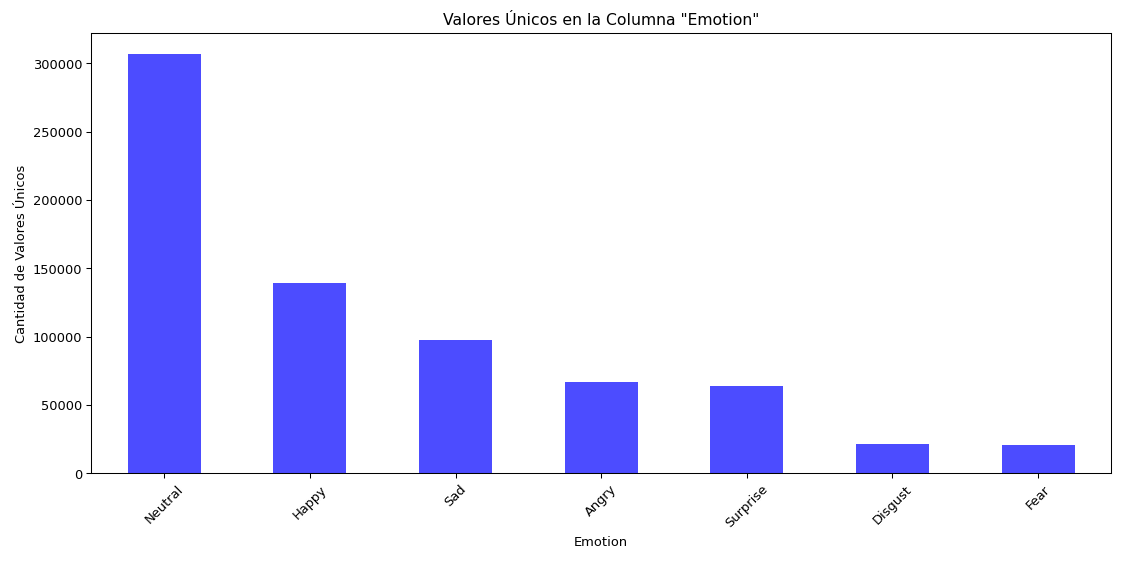

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

emotion_counts = union_train_df['Emotion'].value_counts()

%matplotlib notebook

plt.figure(figsize=(12, 6))
emotion_counts.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Valores Únicos en la Columna "Emotion"')
plt.xlabel('Emotion')
plt.ylabel('Cantidad de Valores Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# No es necesario ejecutar esta parte pq ya tengo los resultados de la union de la primera ejecución

In [28]:
# kind = "Train"

# #croproot = os.path.join(root_path, f"{kind}Crop")


# for sel in tqdm(union_train_df.itertuples()):
#     croppath = sel.Filepath_y
#     #crops = glob(croppath)
#     #if len(crops) == 0:
#     #    continue
#     label = sel.Emotion
#     ilabel = labeldict[label]
#     audiopath = sel.Filepath_x
#     audio_duration = sel.Duration
#     texts = sel.Lemmatized_Tokens
#     rowdf = pd.DataFrame({
#         "filename": audiopath,
#         "impath": croppath,
#         "AudioDuration": audio_duration,
#         "label": label,
#         "Text": texts, 
#         "ilabel": ilabel,
#     }, index=pd.Index([0]))
#     traindf = pd.concat([traindf, rowdf], ignore_index=True)
# traindf.to_csv(train_csv, sep='|', float_format='%.3f') 

# Acá ocupo lo de arriba y me ahorro tiempo

In [29]:
traindf = pd.read_csv(train_csv, sep='|', index_col='Unnamed: 0')
traindf

C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2800478550.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  traindf = pd.read_csv(train_csv, sep='|', index_col='Unnamed: 0')


,filename,impath,AudioDuration,label,ilabel,Text
0,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
1,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
2,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
3,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
4,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
...,...,...,...,...,...,...
705772,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705773,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705774,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705775,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN


In [30]:
df_text_valid = valid_audio.loc[valid_audio['Text_Filter'] == 1, ['KEY', 'Emotion', 'Text_Filter', 'Transcription', 'Lowercase_Transcription', 'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB', 'Set', 'Lemmatized_Tokens', 'Filepath']].copy()
df_audio_valid = valid_audio.loc[valid_audio['Audio_Filter'] == 1, ['KEY', 'Emotion', 'File_Name_Ext', 'Duration', 'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion', 'Signal_to_Noise_Ratio', 'First_Filter', 'Failures', 'Audio_Filter']].copy()

df_text_valid

,KEY,Emotion,Text_Filter,Transcription,Lowercase_Transcription,Text_Without_Stopwords,Tokens,Semantic_Filter,Source_DB,Set,Lemmatized_Tokens,Filepath
Index,,,,,,,,,,,,
0,Validation\Audios\118-30-640x480_1.wav,Neutral,1,OH MY NAME IS GUSHING LITTLE FEATHER I'M APACH...,oh my name is gushing little feather i am apac...,oh name gushing little feather apache present,"['oh', 'name', 'gushing', 'little', 'feather',...",0.133424,AffWild2,val,"['oh', 'name', 'gush', 'little', 'feather', 'a...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
1,Validation\Audios\118-30-640x480_11.wav,Neutral,1,IS ANY MARYLAND BRENDA THIS EVENING AND HE HAS...,is any maryland brenda this evening and he has...,maryland brenda evening asked tell little,"['maryland', 'brenda', 'evening', 'asked', 'te...",0.118613,AffWild2,val,"['maryland', 'brenda', 'evening', 'ask', 'tell...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
2,Validation\Audios\118-30-640x480_13.wav,Neutral,1,AND HE HAS ASKED ME TO TELL YOU IN A VERY LONG...,and he has asked me to tell you in a very long...,asked tell long speech cannot show,"['asked', 'tell', 'long', 'speech', 'can', 'no...",0.145056,AffWild2,val,"['ask', 'tell', 'long', 'speech', 'can', 'not'...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
3,Validation\Audios\118-30-640x480_15.wav,Neutral,1,BUT IN A VERY LONG SPEECH WHICH I CANNOT SHARE...,but in a very long speech which i cannot share...,long speech cannot share presently,"['long', 'speech', 'can', 'not', 'share', 'pre...",0.109739,AffWild2,val,"['long', 'speech', 'can', 'not', 'share', 'pre...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
4,Validation\Audios\118-30-640x480_16.wav,Sad,1,LONG SPEECH WHICH I CANNOT SHARE WITH YOU PRES...,long speech which i cannot share with you pres...,long speech cannot share presently time,"['long', 'speech', 'can', 'not', 'share', 'pre...",0.125342,AffWild2,val,"['long', 'speech', 'can', 'not', 'share', 'pre...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
...,...,...,...,...,...,...,...,...,...,...,...,...
2437,Validation\Audios\015145521.wav,Fear,1,HE'S GOOD WITH NUMBERS TOO AND HE WORKS FOR TH...,he is good with numbers too and he works for t...,good numbers works arras,"['good', 'numbers', 'works', 'arras']",0.186266,AFEW,val,"['good', 'number', 'work', 'arra']",D:\Datasets\MERDWild\Validation\Audios\0151455...
2438,Validation\Audios\015238600.wav,Sad,1,I CAN'T SEE THE MAKE UP,i cannot see the make up,cannot see make,"['can', 'not', 'see', 'make']",0.093120,AFEW,val,"['can', 'not', 'see', 'make']",D:\Datasets\MERDWild\Validation\Audios\0152386...
2439,Validation\Audios\015626280.wav,Sad,1,BUT LEVIN HE THOUGHT YOU'RE TOO BROKE NO,but levin he thought you are too broke no,levin thought broke,"['levin', 'thought', 'broke']",0.157466,AFEW,val,"['levin', 'thought', 'break']",D:\Datasets\MERDWild\Validation\Audios\0156262...


In [31]:
df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].astype(str)

#df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].str.replace('.wav', '')


# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
df_audio_valid['File_Name_Ext'] = df_audio_valid['File_Name_Ext'].str.zfill(5)
df_audio_valid

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,Audio_Filter
Index,,,,,,,,,,,
0,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1.wav,5.000,-27.763789,-8.322293,27.712709,-12.834611,1,0,1
1,Validation\Audios\118-30-640x480_11.wav,Neutral,118-30-640x480_11.wav,5.000,-24.989113,-7.741013,31.618778,-13.112777,1,0,1
2,Validation\Audios\118-30-640x480_13.wav,Neutral,118-30-640x480_13.wav,5.000,-25.925499,-7.741013,30.656403,-12.590220,1,0,1
3,Validation\Audios\118-30-640x480_15.wav,Neutral,118-30-640x480_15.wav,5.000,-28.437517,-11.154938,28.414444,-13.130249,1,0,1
4,Validation\Audios\118-30-640x480_16.wav,Sad,118-30-640x480_16.wav,5.000,-28.731249,-10.502222,28.078568,-13.267942,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2437,Validation\Audios\015145521.wav,Fear,015145521.wav,4.056,-35.648422,-20.992422,41.414802,-3.855075,1,0,1
2438,Validation\Audios\015238600.wav,Sad,015238600.wav,2.928,-47.447955,-25.659241,29.019201,-3.944673,1,0,1
2439,Validation\Audios\015626280.wav,Sad,015626280.wav,3.096,-38.485362,-22.614764,35.334409,-3.944595,1,0,1


In [32]:
df_audio_valid

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,Audio_Filter
Index,,,,,,,,,,,
0,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1.wav,5.000,-27.763789,-8.322293,27.712709,-12.834611,1,0,1
1,Validation\Audios\118-30-640x480_11.wav,Neutral,118-30-640x480_11.wav,5.000,-24.989113,-7.741013,31.618778,-13.112777,1,0,1
2,Validation\Audios\118-30-640x480_13.wav,Neutral,118-30-640x480_13.wav,5.000,-25.925499,-7.741013,30.656403,-12.590220,1,0,1
3,Validation\Audios\118-30-640x480_15.wav,Neutral,118-30-640x480_15.wav,5.000,-28.437517,-11.154938,28.414444,-13.130249,1,0,1
4,Validation\Audios\118-30-640x480_16.wav,Sad,118-30-640x480_16.wav,5.000,-28.731249,-10.502222,28.078568,-13.267942,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
2437,Validation\Audios\015145521.wav,Fear,015145521.wav,4.056,-35.648422,-20.992422,41.414802,-3.855075,1,0,1
2438,Validation\Audios\015238600.wav,Sad,015238600.wav,2.928,-47.447955,-25.659241,29.019201,-3.944673,1,0,1
2439,Validation\Audios\015626280.wav,Sad,015626280.wav,3.096,-38.485362,-22.614764,35.334409,-3.944595,1,0,1


In [33]:
valid_audio = pd.merge(df_audio_valid, df_text_valid, left_on=['KEY', 'Emotion'], right_on=['KEY', 'Emotion'], how='outer')
valid_audio

,KEY,Emotion,File_Name_Ext,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter,Failures,...,Text_Filter,Transcription,Lowercase_Transcription,Text_Without_Stopwords,Tokens,Semantic_Filter,Source_DB,Set,Lemmatized_Tokens,Filepath
0,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1.wav,5.000,-27.763789,-8.322293,27.712709,-12.834611,1,0,...,1.0,OH MY NAME IS GUSHING LITTLE FEATHER I'M APACH...,oh my name is gushing little feather i am apac...,oh name gushing little feather apache present,"['oh', 'name', 'gushing', 'little', 'feather',...",0.133424,AffWild2,val,"['oh', 'name', 'gush', 'little', 'feather', 'a...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
1,Validation\Audios\118-30-640x480_11.wav,Neutral,118-30-640x480_11.wav,5.000,-24.989113,-7.741013,31.618778,-13.112777,1,0,...,1.0,IS ANY MARYLAND BRENDA THIS EVENING AND HE HAS...,is any maryland brenda this evening and he has...,maryland brenda evening asked tell little,"['maryland', 'brenda', 'evening', 'asked', 'te...",0.118613,AffWild2,val,"['maryland', 'brenda', 'evening', 'ask', 'tell...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
2,Validation\Audios\118-30-640x480_13.wav,Neutral,118-30-640x480_13.wav,5.000,-25.925499,-7.741013,30.656403,-12.590220,1,0,...,1.0,AND HE HAS ASKED ME TO TELL YOU IN A VERY LONG...,and he has asked me to tell you in a very long...,asked tell long speech cannot show,"['asked', 'tell', 'long', 'speech', 'can', 'no...",0.145056,AffWild2,val,"['ask', 'tell', 'long', 'speech', 'can', 'not'...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
3,Validation\Audios\118-30-640x480_15.wav,Neutral,118-30-640x480_15.wav,5.000,-28.437517,-11.154938,28.414444,-13.130249,1,0,...,1.0,BUT IN A VERY LONG SPEECH WHICH I CANNOT SHARE...,but in a very long speech which i cannot share...,long speech cannot share presently,"['long', 'speech', 'can', 'not', 'share', 'pre...",0.109739,AffWild2,val,"['long', 'speech', 'can', 'not', 'share', 'pre...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
4,Validation\Audios\118-30-640x480_16.wav,Sad,118-30-640x480_16.wav,5.000,-28.731249,-10.502222,28.078568,-13.267942,1,0,...,1.0,LONG SPEECH WHICH I CANNOT SHARE WITH YOU PRES...,long speech which i cannot share with you pres...,long speech cannot share presently time,"['long', 'speech', 'can', 'not', 'share', 'pre...",0.125342,AffWild2,val,"['long', 'speech', 'can', 'not', 'share', 'pre...",D:\Datasets\MERDWild\Validation\Audios\118-30-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2315,Validation\Audios\015145521.wav,Fear,015145521.wav,4.056,-35.648422,-20.992422,41.414802,-3.855075,1,0,...,1.0,HE'S GOOD WITH NUMBERS TOO AND HE WORKS FOR TH...,he is good with numbers too and he works for t...,good numbers works arras,"['good', 'numbers', 'works', 'arras']",0.186266,AFEW,val,"['good', 'number', 'work', 'arra']",D:\Datasets\MERDWild\Validation\Audios\0151455...
2316,Validation\Audios\015238600.wav,Sad,015238600.wav,2.928,-47.447955,-25.659241,29.019201,-3.944673,1,0,...,1.0,I CAN'T SEE THE MAKE UP,i cannot see the make up,cannot see make,"['can', 'not', 'see', 'make']",0.093120,AFEW,val,"['can', 'not', 'see', 'make']",D:\Datasets\MERDWild\Validation\Audios\0152386...
2317,Validation\Audios\015626280.wav,Sad,015626280.wav,3.096,-38.485362,-22.614764,35.334409,-3.944595,1,0,...,1.0,BUT LEVIN HE THOUGHT YOU'RE TOO BROKE NO,but levin he thought you are too broke no,levin thought broke,"['levin', 'thought', 'broke']",0.157466,AFEW,val,"['levin', 'thought', 'break']",D:\Datasets\MERDWild\Validation\Audios\0156262...
2318,Validation\Audios\015646720.wav,Surprise,015646720.wav,2.040,-37.083908,-22.043003,35.543562,-3.944599,1,0,...,1.0,I KNOW THAT YOU LOVE,i know that you love,know love,"['know', 'love']",0.133565,AFEW,val,"['know', 'love']",D:\Datasets\MERDWild\Validation\Audios\0156467...


In [34]:
validface['Folder'] = validface['Folder'].astype(str)

# Quita la palabra ".wav" de la columna "File_Name_Ext" en train_audio
#trainface['File_Name_Ext'] = trainface['File_Name_Ext'].str.replace('.wav', '')


# Rellena con ceros a la izquierda para que todos los valores tengan 5 dígitos
validface['Folder'] = validface['Folder'].str.zfill(5)
validface

,Unnamed: 0,KEY,Ruta Completa,Similitud,Index,First_Filter,Brightness,Contrast,Entropy,Facial_Points,...,Failures,Folder,Emotion,Set,Source_DB,Image_Filter,Width,Height,File_Name_Ext,Filepath
Index,,,,,,,,,,,,,,,,,,,,,
0,0,Validation\Rostros\000123880\I_1001.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...,0.985733,882233,1,68.238281,20.702724,5.025603,29,...,0,000123880,Surprise,val,AFEW,1,128.0,128.0,I_1001.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...
1,1,Validation\Rostros\000123880\I_1002.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...,0.988940,882234,1,74.116455,33.464360,5.137007,37,...,0,000123880,Surprise,val,AFEW,1,128.0,128.0,I_1002.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...
2,2,Validation\Rostros\000123880\I_1003.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...,0.988098,882235,1,80.077148,44.563600,5.230884,33,...,0,000123880,Surprise,val,AFEW,1,128.0,128.0,I_1003.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...
3,3,Validation\Rostros\000123880\I_1004.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...,0.994537,882236,1,84.629211,58.289023,5.346146,44,...,0,000123880,Surprise,val,AFEW,1,128.0,128.0,I_1004.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...
4,4,Validation\Rostros\000123880\I_1005.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...,0.988146,882237,1,86.865051,48.938227,5.399820,38,...,0,000123880,Surprise,val,AFEW,1,128.0,128.0,I_1005.jpg,D:\Datasets\MERDWild\Validation\Rostros\000123...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203233,206679,Validation\Rostros\video73_9\01311.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...,0.986596,451827,1,141.328503,31.714000,4.610118,107,...,0,video73_9,Surprise,val,AffWild2,1,390.0,602.0,01311.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...
203234,206680,Validation\Rostros\video73_9\01312.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...,0.984794,451828,1,141.749938,26.856964,4.580282,104,...,0,video73_9,Surprise,val,AffWild2,1,387.0,606.0,01312.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...
203235,206681,Validation\Rostros\video73_9\01313.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...,0.987370,451829,1,142.792252,35.866076,4.417435,81,...,0,video73_9,Surprise,val,AffWild2,1,383.0,606.0,01313.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...


In [35]:
valid_audio['File_Name_Ext'] = valid_audio['File_Name_Ext'].str.replace('.wav', '')

union_valid_df = pd.merge(valid_audio, validface, left_on=['File_Name_Ext', 'Emotion'], right_on=['Folder', 'Emotion'], how='outer')
union_valid_df

,KEY_x,Emotion,File_Name_Ext_x,Duration,Average_Power_Level,Peak_Level,Total_Harmonic_Distortion,Signal_to_Noise_Ratio,First_Filter_x,Failures_x,...,Blur,Failures_y,Folder,Set_y,Source_DB_y,Image_Filter,Width,Height,File_Name_Ext_y,Filepath_y
0,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1,5.0,-27.763789,-8.322293,27.712709,-12.834611,1.0,0.0,...,112.802702,0.0,118-30-640x480_1,val,AffWild2,1.0,93.0,115.0,00171.jpg,D:\Datasets\MERDWild\Validation\Rostros\118-30...
1,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1,5.0,-27.763789,-8.322293,27.712709,-12.834611,1.0,0.0,...,96.912153,0.0,118-30-640x480_1,val,AffWild2,1.0,93.0,115.0,00172.jpg,D:\Datasets\MERDWild\Validation\Rostros\118-30...
2,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1,5.0,-27.763789,-8.322293,27.712709,-12.834611,1.0,0.0,...,95.879113,0.0,118-30-640x480_1,val,AffWild2,1.0,94.0,115.0,00173.jpg,D:\Datasets\MERDWild\Validation\Rostros\118-30...
3,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1,5.0,-27.763789,-8.322293,27.712709,-12.834611,1.0,0.0,...,104.736299,0.0,118-30-640x480_1,val,AffWild2,1.0,94.0,116.0,00174.jpg,D:\Datasets\MERDWild\Validation\Rostros\118-30...
4,Validation\Audios\118-30-640x480_1.wav,Neutral,118-30-640x480_1,5.0,-27.763789,-8.322293,27.712709,-12.834611,1.0,0.0,...,94.013998,0.0,118-30-640x480_1,val,AffWild2,1.0,94.0,116.0,00175.jpg,D:\Datasets\MERDWild\Validation\Rostros\118-30...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203534,NaN,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.714000,0.0,video73_9,val,AffWild2,1.0,390.0,602.0,01311.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...
203535,NaN,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.856964,0.0,video73_9,val,AffWild2,1.0,387.0,606.0,01312.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...
203536,NaN,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.866076,0.0,video73_9,val,AffWild2,1.0,383.0,606.0,01313.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...
203537,NaN,Surprise,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.691550,0.0,video73_9,val,AffWild2,1.0,388.0,603.0,01314.jpg,D:\Datasets\MERDWild\Validation\Rostros\video7...


In [36]:
union_valid_df.columns

Index(['KEY_x', 'Emotion', 'File_Name_Ext_x', 'Duration',
       'Average_Power_Level', 'Peak_Level', 'Total_Harmonic_Distortion',
       'Signal_to_Noise_Ratio', 'First_Filter_x', 'Failures_x', 'Audio_Filter',
       'Text_Filter', 'Transcription', 'Lowercase_Transcription',
       'Text_Without_Stopwords', 'Tokens', 'Semantic_Filter', 'Source_DB_x',
       'Set_x', 'Lemmatized_Tokens', 'Filepath_x', 'Unnamed: 0', 'KEY_y',
       'Ruta Completa', 'Similitud', 'Index', 'First_Filter_y', 'Brightness',
       'Contrast', 'Entropy', 'Facial_Points', 'Blur', 'Failures_y', 'Folder',
       'Set_y', 'Source_DB_y', 'Image_Filter', 'Width', 'Height',
       'File_Name_Ext_y', 'Filepath_y'],
      dtype='object')

<IPython.core.display.Javascript object>


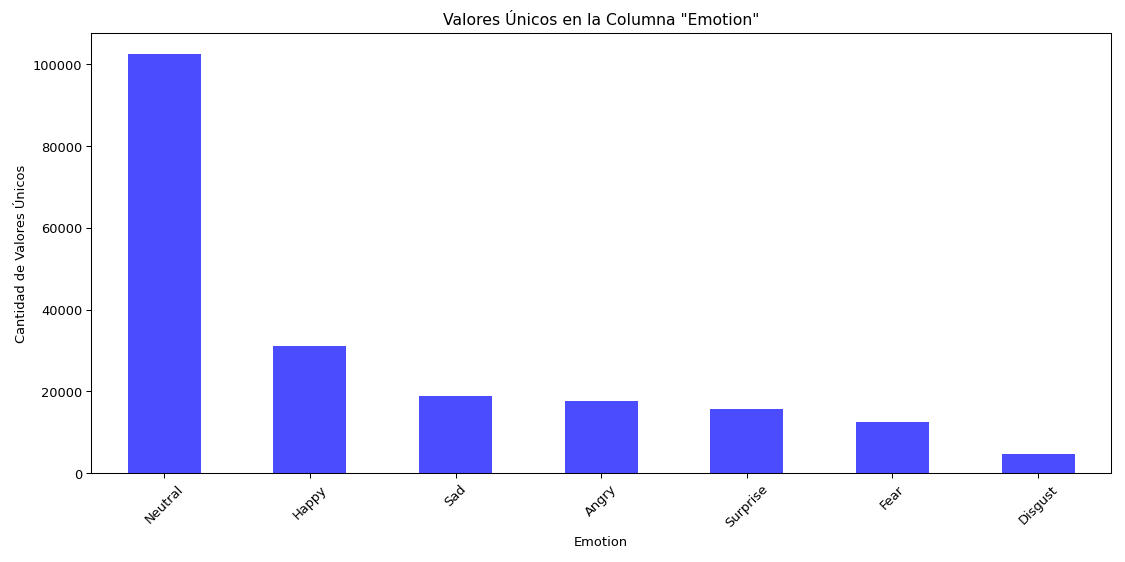

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

emotion_countss = union_valid_df['Emotion'].value_counts()

%matplotlib notebook

plt.figure(figsize=(12, 6))
emotion_countss.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Valores Únicos en la Columna "Emotion"')
plt.xlabel('Emotion')
plt.ylabel('Cantidad de Valores Únicos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# No es necesario ejecutar esta parte pq ya tengo los resultados de la union de la primera ejecución

In [38]:
# kind = "Valid"

# for sel in tqdm(union_valid_df.itertuples(), total=len(union_valid_df)):
#     croppath = sel.Filepath_y
# #     crops = glob(croppath)
# #     if len(crops) == 0:
# #         continue   
#     label = sel.Emotion
#     ilabel = labeldict[label]
#     audiopath = sel.Filepath_x
#     audio_duration = sel.Duration
#     texts = sel.Lemmatized_Tokens
#     rowdf = pd.DataFrame({
#         "filename": audiopath,
#         "impath": croppath,
#         "AudioDuration": audio_duration,
#         "label": label,
#         "Text": texts, 
#         "ilabel": ilabel,
#     }, index=pd.Index([0]))
#     validdf = pd.concat([validdf, rowdf], ignore_index=True)
# validdf.to_csv(val_csv, sep='|', float_format='%.3f') 

# Acá ocupo lo de arriba y me ahorro tiempo

In [39]:
validdf = pd.read_csv(val_csv, sep='|', index_col='Unnamed: 0')
validdf

,filename,impath,AudioDuration,label,ilabel,Text
0,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
1,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
2,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
3,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
4,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
...,...,...,...,...,...,...
203534,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203535,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203536,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203537,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN


In [40]:
#union_valid_df.columns

In [41]:
# import matplotlib.pyplot as plt
# import pandas as pd
# null_counts_valid = union_valid_df.isnull().sum()
# %matplotlib notebook
# plt.figure(figsize=(39, 6))
# null_counts_valid.plot(kind='bar')
# plt.title('Valores Nulos por Columna')
# plt.xlabel('Columna')
# plt.ylabel('Cantidad de Valores Nulos')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

In [42]:
#print(null_counts_valid)

### leer Dataset

In [43]:
def load_set(path):
    return pd.read_csv(path, sep='|')

#traindf = load_set(train_csv)
validdf = load_set(val_csv)


print(f"Tenemos {len(traindf)} eventos en entrenamiento y {len(validdf)} de validacion")

Tenemos 705777 eventos en entrenamiento y 203539 de validacion


In [44]:
validdf

,Unnamed: 0,filename,impath,AudioDuration,label,ilabel,Text
0,0,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
1,1,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
2,2,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
3,3,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
4,4,D:\Datasets\MERDWild\Validation\Audios\118-30-...,D:\Datasets\MERDWild\Validation\Rostros\118-30...,5.0,Neutral,0,"['oh', 'name', 'gush', 'little', 'feather', 'a..."
...,...,...,...,...,...,...,...
203534,203534,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203535,203535,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203536,203536,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN
203537,203537,NaN,D:\Datasets\MERDWild\Validation\Rostros\video7...,NaN,Surprise,6,NaN


In [45]:
#sel = traindf.sample(1).squeeze()
traindf.head(2)

,filename,impath,AudioDuration,label,ilabel,Text
0,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
1,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"


### Features de Imagenes

In [46]:
def readimages(path):
    image = imread(path)
    if len(image.shape) == 2:
        image = gray2rgb(image)
    image = img_as_float32(image)
    image = resize_local_mean(image, (48, 48))
    return image.transpose((2, 0, 1))

def imsamples(imagepaths, batchsize=16):
    images = np.stack([readimages(path) for path in imagepaths], axis=0)
    n_steps = (len(images) // batchsize) + 1
    iterator = np.array_split(images, n_steps)
    for it in iterator:
        yield torch.from_numpy(it).float()

Como ya tenemos los samples listos de imagen, tenemos que obtener los features, promediarlos y guardarlos, asignado a su evento

In [47]:
#VGG19
cfg = {
	'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
	'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
	'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
	'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class ShortVGG(nn.Module):
	def __init__(self, vgg_name='VGG19', numclasses=8, pretrain=False):
		super(ShortVGG, self).__init__()
		self.Name = vgg_name
		self.features = self._make_layers(cfg[vgg_name])
		self.avgpool = nn.AvgPool2d(kernel_size=1, stride=1)
		self.classifier = nn.Linear(512, numclasses)
		if pretrain:
			self.load_pretrain()

	def forward(self, x):
		out = self.features(x)
		out = self.avgpool(out)
		out = out.view(out.size(0), -1)
		out = F.dropout(out, p=0.5, training=self.training)
		out = self.classifier(out)
		return out

	def _make_layers(self, cfg):
		layers = []
		in_channels = 3
		for x in cfg:
			if x == 'M':
				layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
			else:
				layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
									nn.BatchNorm2d(x),
									nn.ReLU(inplace=True)]
				in_channels = x
		
		return nn.Sequential(*layers)

In [48]:
model = torch.load(solo_img_pth)
model.to('cuda').eval()

ShortVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [49]:
traindf

,filename,impath,AudioDuration,label,ilabel,Text
0,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
1,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
2,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
3,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
4,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
...,...,...,...,...,...,...
705772,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705773,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705774,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705775,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN


In [50]:
allpreds = dict()

# num_filas = len(traindf)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_image = traindf.drop_duplicates(subset=['impath']).copy()

# num_filas = len(traindf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_image = traindf_image.dropna(subset=['impath']).copy()

# num_filas = len(traindf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

processed_impath = set()

for sel in tqdm(traindf.itertuples(), total=len(traindf)):
    if isinstance(sel.impath, str):
        if sel.filename not in processed_impath:
            processed_impath.add(sel.impath)
            images = glob(sel.impath)
            images.sort()

            if len(images) == 0 or not os.path.exists(str(sel.filename)):
                continue

            preds = list()

            for sample in imsamples(images):
                data = sample.to("cuda") 
                pred = model(data)
                detached_pred = pred.detach().cpu().numpy()
                preds.append(detached_pred) 

            preds = np.concatenate(preds, axis=0).mean(axis=0)
            preds = np.expand_dims(preds, 0) 

            allpreds[sel.Index] = softmax(preds)
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

100%|███████████████████████████████████████████████████████████████████████| 705777/705777 [1:41:27<00:00, 115.94it/s]


In [51]:
with open(train_img, "wb") as file:
    pickle.dump(allpreds, file)

In [52]:
allpreds = dict()

# num_filas = len(validdf)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_image = validdf.drop_duplicates(subset=['impath']).copy()

# num_filas = len(validdf_image)

# print(f"El DataFrame tiene {num_filas} filas.")

# validdf_image = validdf_image.dropna(subset=['impath']).copy()

# num_filas = len(validdf_image)

# print(f"El DataFrame tiene {num_filas} filas.")


processed_impath = set()


for sel in tqdm(validdf.itertuples(), total=len(validdf)):
    if isinstance(sel.impath, str):
        if sel.filename not in processed_impath:
            processed_impath.add(sel.impath)
            images = glob(sel.impath)
            images.sort()

            if len(images) == 0:
                continue

            if isinstance(sel.filename, str):
                if not os.path.exists(sel.filename):
                    continue

                preds = list()

                for sample in imsamples(images):
                    data = sample.to("cuda") 
                    pred = model(data) 
                    detached_pred = pred.detach().cpu().numpy()
                    preds.append(detached_pred)

                preds = np.concatenate(preds, axis=0).mean(axis=0)
                preds = np.expand_dims(preds, 0) 

                allpreds[sel.Index] = softmax(preds) 
            else:
                allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

100%|█████████████████████████████████████████████████████████████████████████| 203539/203539 [27:07<00:00, 125.10it/s]


In [53]:
print(allpreds[100])

[[4.0733241e-03 1.9801051e-10 3.4494970e-14 9.9590957e-01 1.3262924e-10
  4.2262149e-12 1.7111981e-05]]


In [54]:
with open(valid_img, "wb") as file:
    pickle.dump(allpreds, file)

In [55]:
torch.cuda.empty_cache()

del(model)
print("Eliminado")

Eliminado


### Features de Audio

In [56]:
def get_spect(path, duration):
    wav, sr = librosa.load(path, sr=22400, duration=np.minimum(duration, 7))
#     print("hola")
#     print(sel.AudioDuration)
#     if math.isnan(sel.AudioDuration):
#         print("entró")
#         duration = 0
#         print("caca")

    if duration >= 7:
        wav = librosa.util.pad_center(data=wav, size=22400*7, mode="constant")

    spect = librosa.feature.melspectrogram(
        y=wav,
        sr=22400,
        n_fft=1024,
        hop_length=(22400*7)//255,
        n_mels=256,  
    )

    spect_db = librosa.power_to_db(spect, ref=np.max, top_db=80)

    norm_spect = colormaps["jet"](Normalize()(spect_db))

    spectrogram = np.transpose(norm_spect[...,:-1], (2,0,1))

    return torch.from_numpy(np.expand_dims(spectrogram, 0)).float()

Importamos el modelo

In [57]:
model = torch.load(solo_audios_pth)
model.to('cuda').eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
import math

allpreds = dict()

# mask = traindf['AudioDuration'].isna()

# df_with_nan_duration = traindf[mask]

# num_filas = len(traindf)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_audio = traindf.drop_duplicates(subset=['filename']).copy()

# num_filas = len(traindf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")

# traindf_audio = traindf_audio.dropna(subset=['filename']).copy()

# num_filas = len(traindf_audio)

# print(f"El DataFrame tiene {num_filas} filas.")

processed_filenames = set()

for sel in tqdm(traindf.itertuples()):
    if isinstance(sel.filename, str) and not math.isnan(sel.AudioDuration):
        if sel.filename not in processed_filenames:
            processed_filenames.add(sel.filename)
            spectrogram = get_spect(sel.filename, sel.AudioDuration)
            video_id, _ = os.path.splitext(os.path.basename(sel.filename))
            data = spectrogram.to("cuda")
            pred = model(data)
            detached_pred = pred.detach().cpu().numpy()
            allpreds[sel.Index] = softmax(detached_pred)
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

with open(train_audios, "wb") as file:
    pickle.dump(allpreds, file)

705777it [05:58, 1968.61it/s] 


In [59]:
# import pickle
# from tqdm import tqdm
# import math
# allpreds = dict()

# # mask = validdf['AudioDuration'].isna()

# # df_with_nan_duration = validdf[mask]


# for sel in tqdm(validdf.itertuples()):
#     if isinstance(sel.filename, str):
#         #print(type(sel.AudioDuration))
#         #print(sel.AudioDuration)
#         if not math.isnan(sel.AudioDuration):
#             #print(sel.AudioDuration)
#             spectrogram = get_spect(sel.filename, sel.AudioDuration)
#             #print(spectrogram)       
#             if spectrogram is not None:
#                 video_id, _ = os.path.splitext(os.path.basename(sel.filename))
#                 data = spectrogram.to("cuda")
#                 pred = model(data)
#                 detached_pred = pred.detach().cpu().numpy()
#                 #print(spectrogram)
#                 allpreds[sel.Index] = softmax(detached_pred)  

# with open(valid_audios, "wb") as file:
#     pickle.dump(allpreds, file)

In [60]:
import pickle
from tqdm import tqdm
import math
allpreds = dict()


# mask = validdf['AudioDuration'].isna()
# df_with_nan_duration = validdf[mask]
# num_filas = len(validdf)
# print(f"El DataFrame tiene {num_filas} filas.")
# validdf_audio = validdf.drop_duplicates(subset=['filename']).copy()
# num_filas = len(validdf_audio)
# print(f"El DataFrame tiene {num_filas} filas.")
# validdf_audio = validdf_audio.dropna(subset=['filename']).copy()
# num_filas = len(validdf_audio)
# print(f"El DataFrame tiene {num_filas} filas.")

processed_filenames = set()

for sel in tqdm(validdf.itertuples()):
    if isinstance(sel.filename, str) and not math.isnan(sel.AudioDuration):
        if sel.filename not in processed_filenames:
            processed_filenames.add(sel.filename)
            spectrogram = get_spect(sel.filename, sel.AudioDuration)
            video_id, _ = os.path.splitext(os.path.basename(sel.filename))
            data = spectrogram.to("cuda")
            pred = model(data)
            detached_pred = pred.detach().cpu().numpy()
            allpreds[sel.Index] = softmax(detached_pred)  
        else:
            allpreds[sel.Index] = np.zeros((7,), dtype=np.float32)

with open(valid_audios, "wb") as file:
    pickle.dump(allpreds, file)

203539it [01:00, 3372.11it/s] 


In [61]:
print(allpreds[100])

[0. 0. 0. 0. 0. 0. 0.]


In [62]:
torch.cuda.empty_cache()

del(model)

In [63]:
traindf

,filename,impath,AudioDuration,label,ilabel,Text
0,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
1,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
2,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
3,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
4,D:\Datasets\MERDWild\Training\Audios\1-30-1280...,D:\Datasets\MERDWild\Training\Rostros\1-30-128...,5.0,Happy,4,"['wait', 'half', 'like', 'let', 'we', 'begin']"
...,...,...,...,...,...,...
705772,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705773,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705774,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN
705775,NaN,D:\Datasets\MERDWild\Training\Rostros\dia88_ut...,NaN,Neutral,0,NaN


### Features de Texto

In [64]:
bertmodels = 'bert-large-nli-stsb-mean-tokens'
model = SentenceTransformer(bertmodels)

traindf['Text'] = traindf['Text'].astype(str)
validdf['Text'] = validdf['Text'].astype(str)

# traindf_text = traindf.drop_duplicates(subset=['filename', 'Text']).copy()
# validdf_text = validdf.drop_duplicates(subset=['filename', 'Text']).copy()
# print("Cantidad de datos en traindf unicos:", len(traindf_text))
# print("Cantidad de datos en validdf unicos:", len(validdf_text))


train_embed = model.encode(traindf.Text.to_list())
valid_embed = model.encode(validdf.Text.to_list()) 

clf = MLPClassifier(
    hidden_layer_sizes=(500, 300,), 
    learning_rate_init=1e-4,
    tol=1e-6,
    early_stopping=True,
    verbose=True,
)

clf.fit(train_embed, traindf.ilabel.tolist())

Iteration 1, loss = 0.68038497
Validation score: 0.849231
Iteration 2, loss = 0.38437951
Validation score: 0.860991
Iteration 3, loss = 0.36076797
Validation score: 0.855522
Iteration 4, loss = 0.35207145
Validation score: 0.856358
Iteration 5, loss = 0.34701147
Validation score: 0.861812
Iteration 6, loss = 0.34311717
Validation score: 0.862011
Iteration 7, loss = 0.34017718
Validation score: 0.864292
Iteration 8, loss = 0.33795567
Validation score: 0.862663
Iteration 9, loss = 0.33603911
Validation score: 0.862847
Iteration 10, loss = 0.33468723
Validation score: 0.863499
Iteration 11, loss = 0.33395240
Validation score: 0.862507
Iteration 12, loss = 0.33297791
Validation score: 0.863853
Iteration 13, loss = 0.33240662
Validation score: 0.864405
Iteration 14, loss = 0.33177704
Validation score: 0.863541
Iteration 15, loss = 0.33127780
Validation score: 0.863980
Iteration 16, loss = 0.33076105
Validation score: 0.863739
Iteration 17, loss = 0.33070822
Validation score: 0.863867
Iterat

MLPClassifier(early_stopping=True, hidden_layer_sizes=(500, 300),
              learning_rate_init=0.0001, tol=1e-06, verbose=True)

In [65]:
train_preds = clf.predict_proba(train_embed)
valid_preds = clf.predict_proba(valid_embed)

train_pkls = {ix: p for ix, p in zip(traindf.index, train_preds)}  
valid_pkls = {ix: p for ix, p in zip(traindf.index, valid_preds)}  

print(train_pkls[0])

[1.06590334e-04 2.11960649e-09 6.53111698e-08 4.27899238e-07
 9.99892235e-01 4.31719975e-08 6.96716995e-07]


In [66]:
with open(train_text, "wb") as file:
    pickle.dump(train_pkls, file)

with open(valid_text, "wb") as file:
    pickle.dump(valid_pkls, file)

## EmbraceNet

In [67]:
# Modulo Suma ponderada
class WeightedSum(nn.Module):
    def __init__(self, number_modals, outchannels, probabilities=None,
                                trainable=False, mode='', device=torch.device('cpu')):
        super(WeightedSum, self).__init__()
        self.NumberModalities = number_modals
        self.Mode = mode
        self.Probabilities = probabilities
        self.Device = device
        self.set_weights(outchannels, trainable)

    def set_weights(self, outchannels, trainable):
        i = 0
        if self.Mode == 'convs':
            setattr(self, 'Weight_%d' % (i), nn.Conv1d(self.NumberModalities, outchannels, kernel_size=1, stride=1))
            if not trainable:
                getattr(self, 'Weight_%d' % (i)).weight.requires_grad = False

        elif self.Mode == 'tensor':
            if self.Probabilities is not None:
                tt = torch.tensor(self.Probabilities, dtype=torch.float)
            else:
                tt = torch.ones(self.NumberModalities, outchannels, dtype=torch.float)
            tt = torch.div(tt, torch.sum(tt, dim=0, keepdim=True)).to(self.Device)
            self.Weight_1 = nn.Parameter(tt, requires_grad=trainable)
        else:
            raise NameError('{} is not supported yet'.format(self.Mode))

    def forward(self, outs, availability):
        b, c, n = outs.shape
        # Obtiene los pesos configurados.
        W = getattr(self, 'Weight_%d' % (1))
        if self.Mode == 'convs':
            out = W(outs)
        elif self.Mode == 'tensor':
            W = torch.stack([W] * b).view(b, c)
            W = torch.mul(W, availability)
            W = torch.div(W, torch.sum(W, dim=-1, keepdim=True)).view(b, c, 1)
            out = torch.zeros(b, 1, n, dtype=torch.float, device=self.Device)
            for i, o in enumerate(outs):
                out[i, :, :] = (torch.mm(o.T, W[i].float())).T

        return out.view(out.shape[0], out.shape[-1])

In [68]:
# Embracenet
class EmbraceNet(nn.Module):
    def __init__(self, input_size_list=[], embracement_size=32, docker_arch=[], device=torch.device('cpu')):
        super(EmbraceNet, self).__init__()

        self.input_size_list = input_size_list
        self.embracement_size = embracement_size
        self.bypass_docking = self.set_dockers(docker_arch)
        self.Device = device

    def set_dockers(self, docker_architecture=[]):
        bypass = True
        for i, arch in enumerate(docker_architecture):
            bypass = False
            layers = []
            inC = self.input_size_list[i]
            for l in arch:
                if l == 'D':
                    layers += [nn.Dropout()]
                elif l == 'R':
                    layers += [nn.ReLU()]
                else:
                    layers += [nn.Linear(inC, l)]
                    inC = l
            setattr(self, 'docking_%d' % (i), nn.Sequential(*layers))
        return bypass

    def forward(self, input_list, availabilities=None, selection_probabilities=None):
        assert len(input_list) == len(self.input_size_list)
        num_modalities = len(input_list)
        batch_size = input_list[0].shape[0]

        docking_output_list = []

        if self.bypass_docking:
            docking_output_list = input_list
        else:
            for i, input_data in enumerate(input_list):
                x = getattr(self, 'docking_%d' % (i))(input_data)
                x = nn.functional.relu(x)
                docking_output_list.append(x)

        if availabilities is None:
            availabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.Device)
        else:
            availabilities = availabilities.float().to(self.Device)

        if selection_probabilities is None:
            selection_probabilities = torch.ones(batch_size, len(input_list), dtype=torch.float, device=self.Device)
        else:
            selection_probabilities = selection_probabilities.float().to(self.Device)

        selection_probabilities = torch.mul(selection_probabilities, availabilities)
        probability_sum = torch.sum(selection_probabilities, dim=-1, keepdim=True)
        selection_probabilities = torch.div(selection_probabilities, probability_sum)

        docking_output_stack = torch.stack(docking_output_list, dim=-1)

        modality_indices = torch.multinomial(selection_probabilities, num_samples=self.embracement_size, replacement=True)
        modality_toggles = nn.functional.one_hot(modality_indices, num_classes=num_modalities).float()

        embracement_output_stack = torch.mul(docking_output_stack, modality_toggles)
        embracement_output = torch.sum(embracement_output_stack, dim=-1)

        return embracement_output

In [69]:
# Modelo New Four
class ModelNewFour(nn.Module):
    def __init__(self, num_classes, input_sizes, final_input_sizes,
                 embrace2_param, embrace3_param, wsum_confg,
                 device, trainable_probs, useffinal, use_ws,
                 use_ll, ll_configs):
        super(ModelNewFour, self).__init__()

        self.NClasses = num_classes
        self.InputSize = input_sizes
        self.FinalInputSize = final_input_sizes
        self.Device = device

        self.EmbNet2 = EmbraceNet(**embrace2_param)
        self.EmbNet3 = EmbraceNet(**embrace3_param)
        self.WeightedSum = WeightedSum(**wsum_confg)

        self.UseLL1 = use_ll[0]
        self.UseLL2 = use_ll[1]
        self.UseLL3 = use_ll[2]
        self.UseFinalsInFinal = useffinal
        self.UseWSum = use_ws
        self.TrainableProbs = trainable_probs

        self.initProbabilities()

        if self.UseLL1:
            self.LL1 = self.gen_ll(**ll_configs[0])
        if self.UseLL2:
            self.LL2 = self.gen_ll(**ll_configs[1])
        if self.UseLL3:
            self.LL3 = self.gen_ll(**ll_configs[2])

    def gen_ll(self, config, embrace_size):
        layers = []
        inC = embrace_size
        for x in config:
            if x == 'D':
                layers += [nn.Dropout()]
            elif x == 'R':
                layers += [nn.ReLU()]
            else:
                layers += [nn.Linear(inC, x)]
                inC = x

        return nn.Sequential(*layers)

    def initProbabilities(self):
        p1 = torch.ones(1, self.InputSize, dtype=torch.float)
        p2 = torch.ones(1, self.InputSize, dtype=torch.float)
        p3 = torch.ones(1, self.FinalInputSize, dtype=torch.float)
        self.p1 = torch.div(p1, torch.sum(p1, dim=-1, keepdim=True)).to(self.Device)
        self.p2 = torch.div(p2, torch.sum(p2, dim=-1, keepdim=True)).to(self.Device)
        self.p3 = torch.div(p3, torch.sum(p3, dim=-1, keepdim=True)).to(self.Device)

        self.P1 = nn.Parameter(p1, requires_grad=self.TrainableProbs)
        self.P2 = nn.Parameter(p2, requires_grad=self.TrainableProbs)
        self.P3 = nn.Parameter(p3, requires_grad=self.TrainableProbs)

    def forward(self, outputs2, available):
        batch_size = outputs2[0].shape[0]
        availabilities = torch.ones(batch_size, self.FinalInputSize, dtype=torch.float, device=self.Device)

        probabilities2 = torch.stack([self.p2] * batch_size, dim=0).view(batch_size, self.InputSize)
        out2 = self.EmbNet2.forward(outputs2, available, probabilities2)
        if self.UseLL2:
            out2 = self.LL2(out2)

        wsout = self.WeightedSum.forward(torch.stack(outputs2, dim=1), available)
        concat = torch.cat(outputs2, dim=-1)

        probabilities3 = torch.stack([self.p3] * batch_size, dim=0).view(batch_size, self.FinalInputSize)

        if not self.UseFinalsInFinal:
            availabilities[:, -1] = 0.0
        if not self.UseWSum:
            availabilities[:, -2] = 0.0

        out = self.EmbNet3.forward([out2, wsout, concat], availabilities, probabilities3)

        if self.UseLL3:
            out = self.LL3(out)

        return out

In [70]:
ABLATIONS = ["IAT","IXX","XAX","XXT", "IAX", "IXT", "XAT"]
print(ABLATIONS)

['IAT', 'IXX', 'XAX', 'XXT', 'IAX', 'IXT', 'XAT']


### DatasetEmbNet

In [71]:
class DatasetEmbNet(Dataset):
    def __init__(self, csvfile, featroot="", kind='train', ablation="XXX", transform=None):
        super(DatasetEmbNet, self).__init__()

        self.transform = transform
        self.modalities = ["image", "audio", "text"]

        df = pd.read_csv(csvfile, sep='|')
        df = df[df['label'] != "Other"]

        self.features = {t: self.load_pickledict(os.path.join(featroot, f"{kind}_{t}_feats.pkl")) for t in self.modalities }
        self.ablation = ablation
        indexes = reduce(np.intersect1d, [list(self.features[mod].keys()) for mod in self.modalities])
        self.dataframe = df.loc[pd.Index(indexes)]
        
        df
        
    def load_pickledict(self, path):
        with open(path, "rb") as file:
            data = pickle.load(file)
        return data

    def ablate(self, index):
        outdata = dict()
        jointprob = np.zeros((3,))
        for n, k in enumerate(self.ablation):
            if k == "X":
                # Si no hay datos para esta modalidad, se crea un arreglo de ceros.
                outdata[self.modalities[n]] = np.zeros((7,), dtype=np.float32)
                continue
            elif k == "I":
                # Si la modalidad es imagen, se obtienen las características de imagen.
                outdata[self.modalities[n]] = self.features["image"][index].squeeze()
            elif k == "A":
                # Si la modalidad es audio, se obtienen las características de audio.
                outdata[self.modalities[n]] = self.features["audio"][index].squeeze()
            elif k == "T":
                # Si la modalidad es texto, se obtienen las características de texto.
                outdata[self.modalities[n]] = self.features["text"][index]
            else:
                raise ValueError("Esto no debería pasar")
            jointprob[n] = 1.
        
        # Registra la disponibilidad de las modalidades en el diccionario de datos.
        outdata["availables"] = jointprob
        return outdata

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.to_list()
        sam = self.dataframe.iloc[index]
        sample = self.ablate(sam["Unnamed: 0"])
        sample["label"] = np.array([sam.ilabel])
        if self.transform:
            sample = self.transform(sample)
        return sample

In [72]:
class FusionTransformer(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        return {key:torch.from_numpy(val) for key,val in sample.items()}

### Entrenamiento

In [73]:
config = {
    "num_classes": 7, 
    "input_sizes": 3, 
    "final_input_sizes": 3, 

    "embrace2_param": {
        "input_size_list": [7, 7, 7], 
        "embracement_size": 16,
        "docker_arch": [[32, "D", 16], [32, "D", 16], [32, "D", 16]],  
        "device": torch.device('cpu') 
    },

    "embrace3_param": {
        "input_size_list": [16, 7, 21],
        "embracement_size": 16,
        "docker_arch": [[16], [16], [16]],
        "device": torch.device('cpu')
    },

    "wsum_confg": {
        "number_modals": 3, 
        "outchannels": 1, 
        "probabilities": None, 
        "trainable": False, 
        "mode": "tensor", 
        "device": torch.device('cpu')  
    },

    "device": torch.device('cpu'), 
    "trainable_probs": False, 
    "useffinal": True, 
    "use_ws": True,
    
    "use_ll": [False, False, True],  

    "ll_configs": [{}, {}, {"config": [7, "R"], "embrace_size": 16}]
}

Experimento IAT


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:43<00:00, 229.14it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Neutral      0.529     0.903     0.667     83499
       Angry      0.185     0.178     0.182      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.000     0.000     0.000     21224
         Sad      0.212     0.088     0.124     17208
    Surprise      0.000     0.000     0.000     12519

    accuracy                          0.494    159309
   macro avg      0.132     0.167     0.139    159309
weighted avg      0.312     0.494     0.374    159309



C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


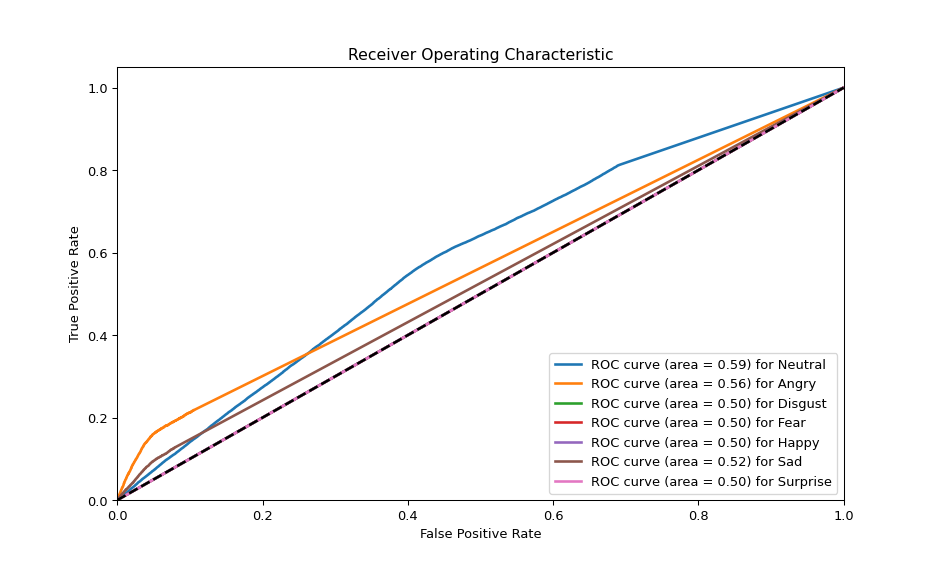

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


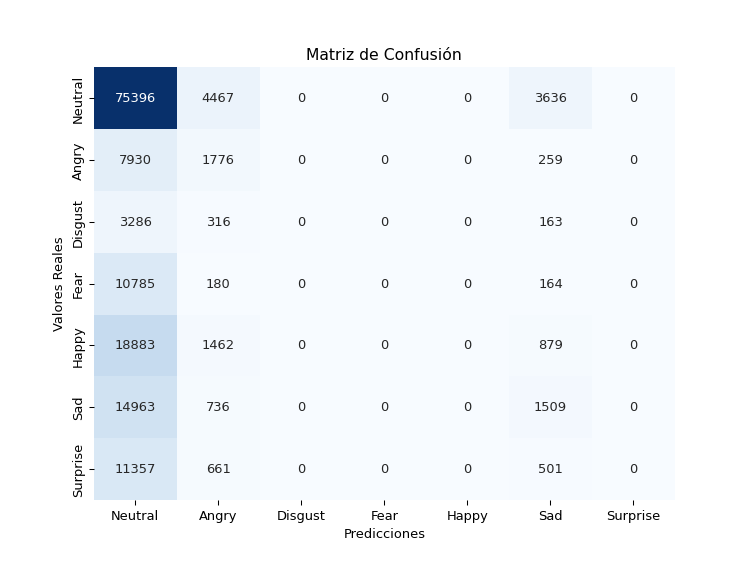

Accuracy: 0.4938892341298985
----------------------------------------------------------------------------------------------
Experimento IXX


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:42<00:00, 235.11it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.520     0.552     0.536     83499
       Angry      0.174     0.176     0.175      9965
     Disgust      0.107     0.149     0.125      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.243     0.362     0.291     21224
         Sad      0.118     0.052     0.072     17208
    Surprise      0.040     0.052     0.045     12519

    accuracy                          0.362    159309
   macro avg      0.172     0.192     0.178    159309
weighted avg      0.335     0.362     0.345    159309



<IPython.core.display.Javascript object>


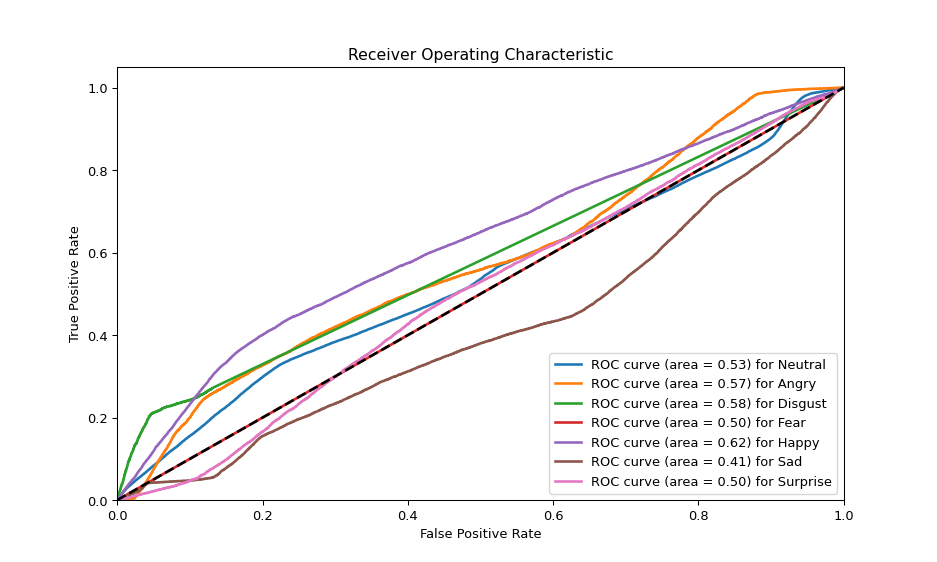

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


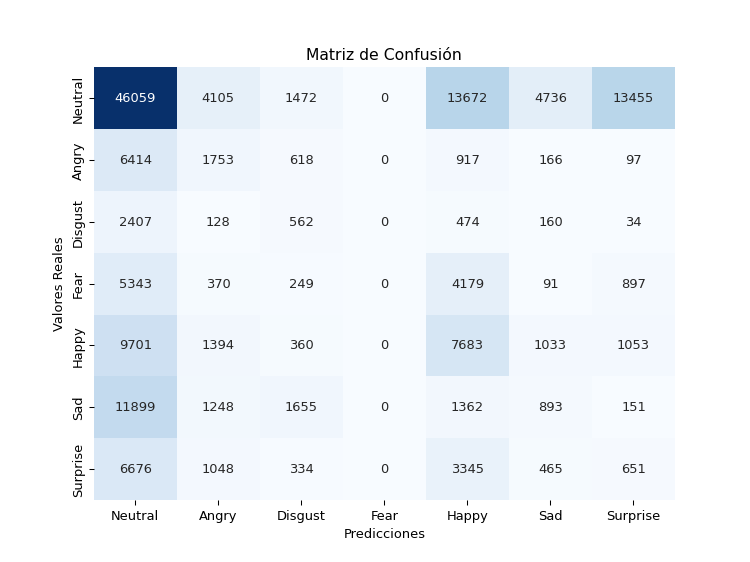

Accuracy: 0.3615677708101865
----------------------------------------------------------------------------------------------
Experimento XAX


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:41<00:00, 237.78it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.524     0.999     0.688     83499
       Angry      0.369     0.003     0.006      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.286     0.000     0.001     21224
         Sad      0.000     0.000     0.000     17208
    Surprise      0.203     0.001     0.002     12519

    accuracy                          0.524    159309
   macro avg      0.198     0.143     0.100    159309
weighted avg      0.352     0.524     0.361    159309



<IPython.core.display.Javascript object>


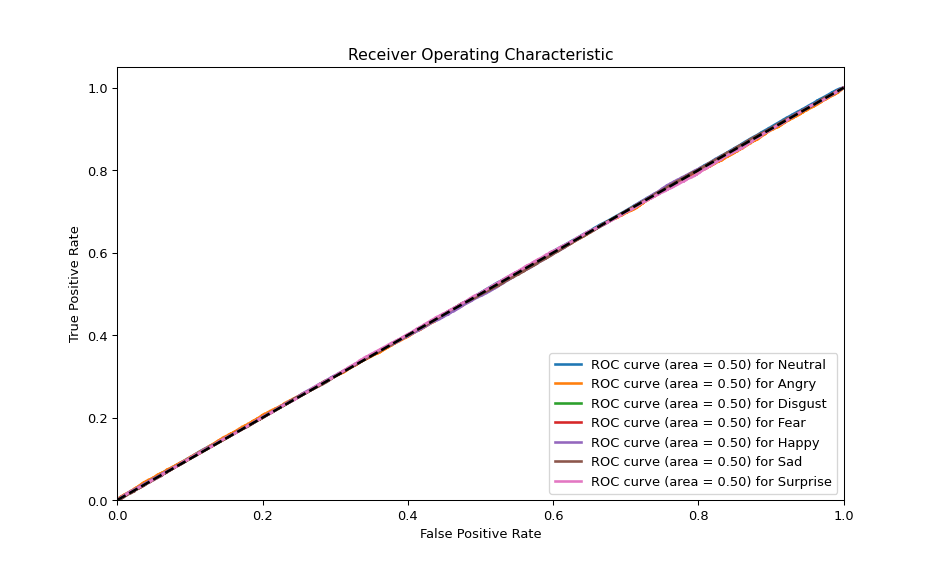

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


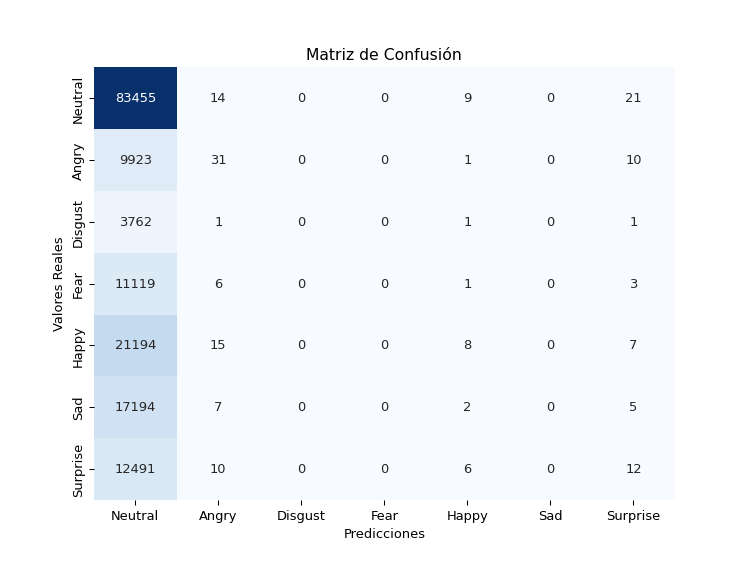

Accuracy: 0.5241762863366163
----------------------------------------------------------------------------------------------
Experimento XXT


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:42<00:00, 236.65it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.564     0.735     0.638     83499
       Angry      0.158     0.161     0.160      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.037     0.010     0.015     11129
       Happy      0.199     0.179     0.189     21224
         Sad      0.209     0.083     0.119     17208
    Surprise      0.084     0.079     0.081     12519

    accuracy                          0.435    159309
   macro avg      0.179     0.178     0.172    159309
weighted avg      0.364     0.435     0.390    159309



<IPython.core.display.Javascript object>


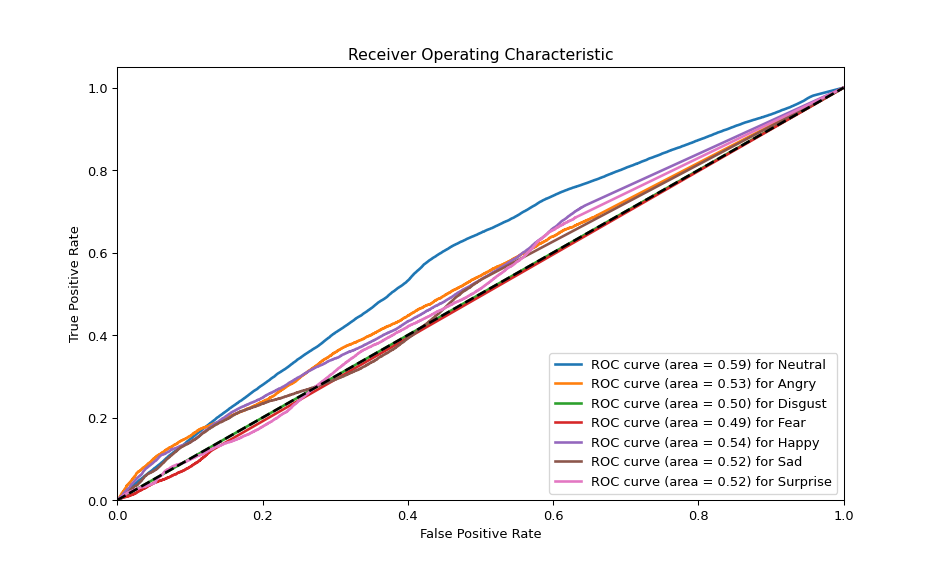

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


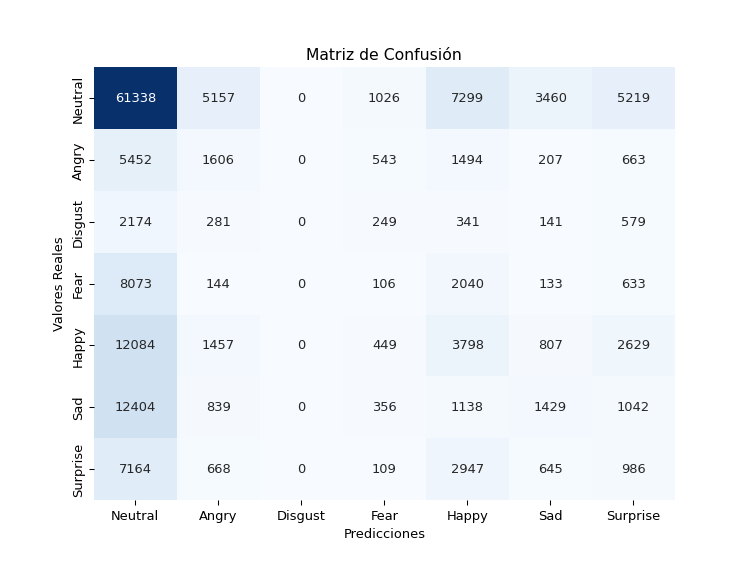

Accuracy: 0.4347714190660917
----------------------------------------------------------------------------------------------
Experimento IAX


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:44<00:00, 223.84it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

              precision    recall  f1-score   support

     Neutral      0.513     0.612     0.559     83499
       Angry      0.179     0.144     0.159      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.237     0.385     0.294     21224
         Sad      0.000     0.000     0.000     17208
    Surprise      0.041     0.057     0.048     12519

    accuracy                          0.386    159309
   macro avg      0.139     0.171     0.151    159309
weighted avg      0.315     0.386     0.346    159309



<IPython.core.display.Javascript object>


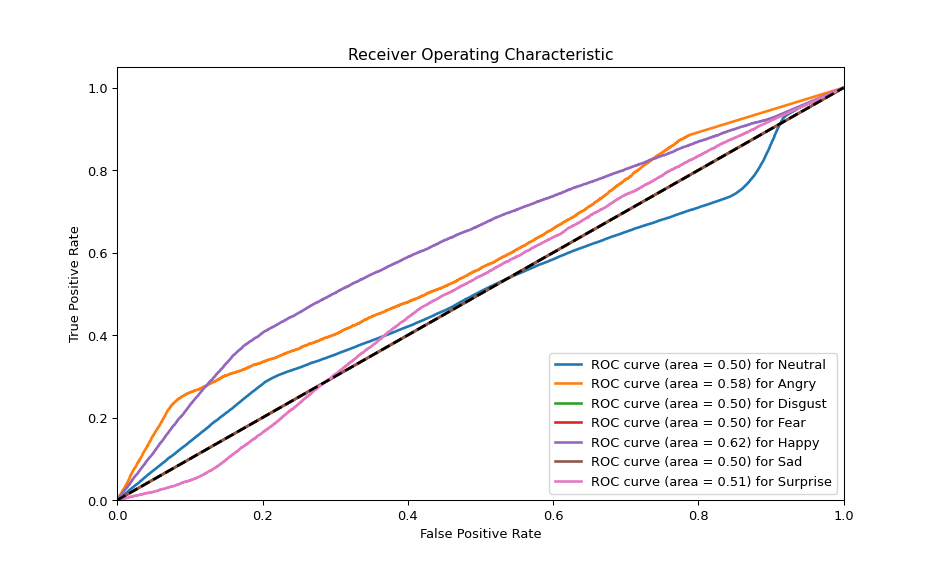

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


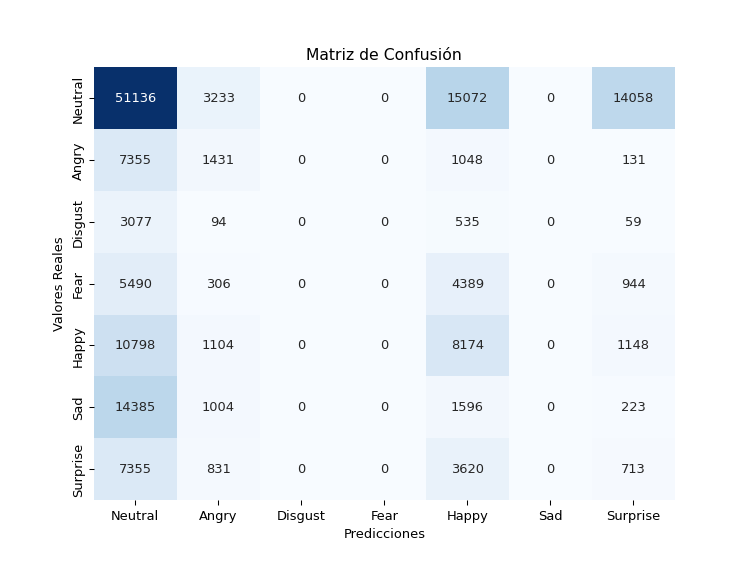

Accuracy: 0.3857534728107012
----------------------------------------------------------------------------------------------
Experimento IXT


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:40<00:00, 243.10it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Neutral      0.550     0.857     0.670     83499
       Angry      0.177     0.171     0.174      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.200     0.184     0.192     21224
         Sad      0.000     0.000     0.000     17208
    Surprise      0.000     0.000     0.000     12519

    accuracy                          0.484    159309
   macro avg      0.132     0.173     0.148    159309
weighted avg      0.326     0.484     0.388    159309



C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


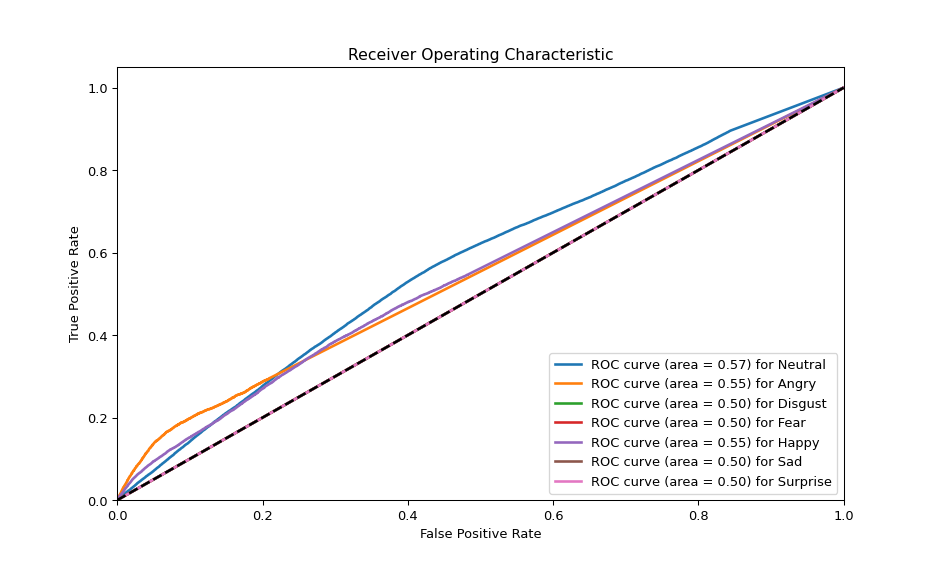

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


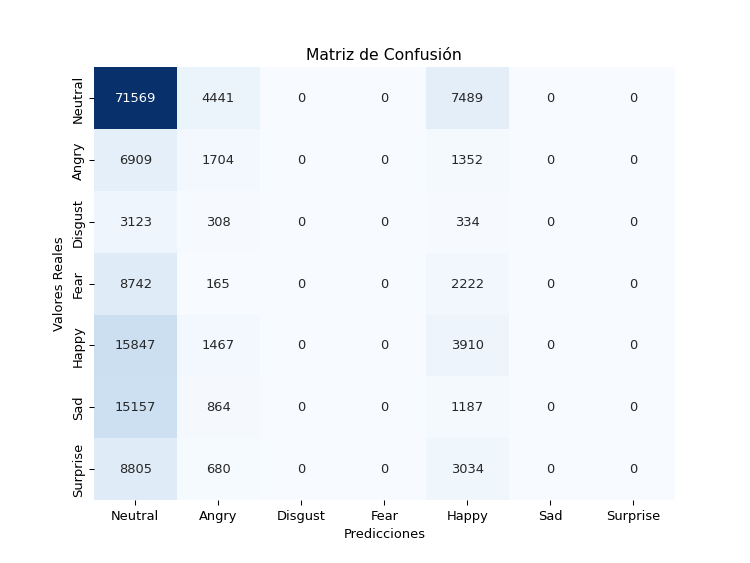

Accuracy: 0.4844861244499683
----------------------------------------------------------------------------------------------
Experimento XAT


C:\Users\facun\AppData\Local\Temp\ipykernel_17024\2801146037.py:10: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csvfile, sep='|')


586089
159309


Validacion: 100%|█████████████████████████████████████████████████████████████████| 9957/9957 [00:42<00:00, 231.68it/s]
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     Neutral      0.550     0.829     0.662     83499
       Angry      0.182     0.164     0.173      9965
     Disgust      0.000     0.000     0.000      3765
        Fear      0.000     0.000     0.000     11129
       Happy      0.196     0.165     0.179     21224
         Sad      0.219     0.085     0.122     17208
    Surprise      0.000     0.000     0.000     12519

    accuracy                          0.476    159309
   macro avg      0.164     0.178     0.162    159309
weighted avg      0.350     0.476     0.395    159309



C:\Users\facun\anaconda3\envs\gpu\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>


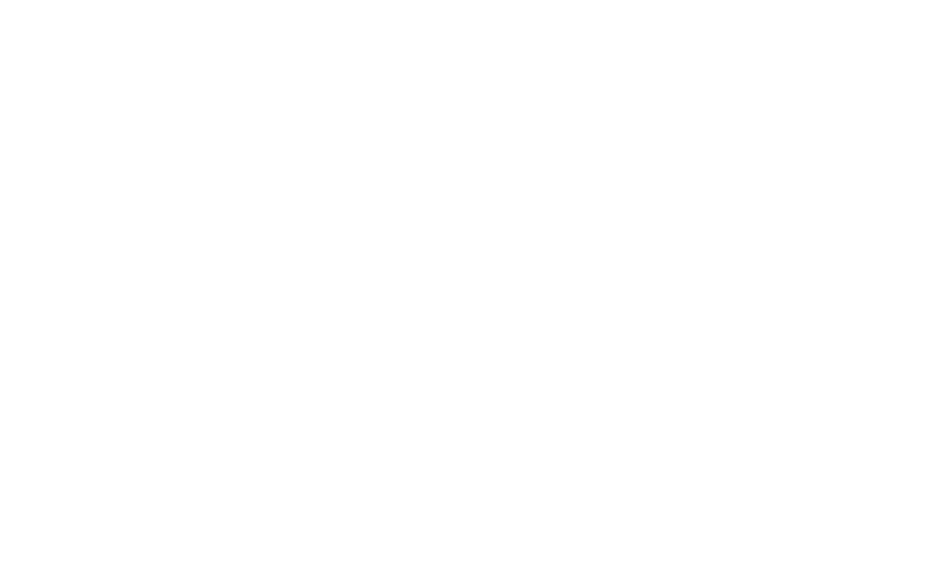

----------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


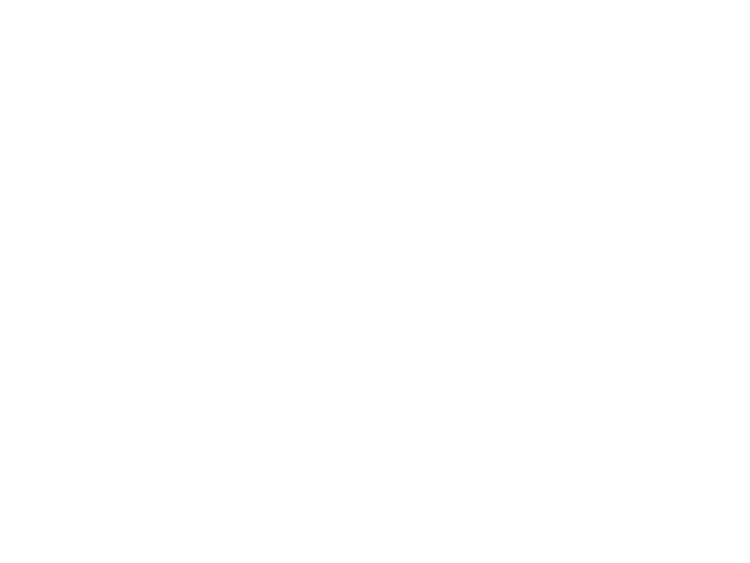

Accuracy: 0.476081075143275
----------------------------------------------------------------------------------------------


In [74]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

n_epochs = 20 
results = dict()

for ablation in ABLATIONS:
    print(f"Experimento {ablation}")

    trainset = DatasetEmbNet(
        csvfile=train_csv,
        featroot=save_pickle,
        kind='train',
        ablation=ablation,
        transform=FusionTransformer(),
    )

    validset = DatasetEmbNet(
        csvfile=val_csv,
        featroot=save_pickle,
        kind='valid',
        ablation=ablation,
        transform=FusionTransformer(),
    )
    train_dataloader = DataLoader(trainset, batch_size=16, shuffle=True)
    valid_dataloader = DataLoader(validset, batch_size=16)

    train_size = len(train_dataloader.dataset)
    valid_size = len(valid_dataloader.dataset)
    print(train_size)
    print(valid_size)
    model = ModelNewFour(**config)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(n_epochs):
        tqdm_train = tqdm(total=len(train_dataloader), desc=f"Train [{epoch+1}/{n_epochs}]")
        train_acc = 0.
        for sample in train_dataloader:
            tqdm_train.update(n=1)
            face_data = sample['image']
            audio_data = sample['audio']
            text_data = sample['text']
            label = sample['label'].squeeze() #torch.argmax(, dim=-1)#.flatten()
            avails = sample['availables']
            pred = model([face_data, audio_data, text_data], avails)
            loss = criterion(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_acc += (pred.argmax(1) == label).float().sum().item() / train_size
            tqdm_train.set_postfix_str(f"Loss={loss.item():.4f} - Accuracy = {train_acc:.4f}", refresh=True)
        
        tqdm_train.close()


    all_labels, all_preds = np.empty((0)), np.empty((0, 7))
    model.eval()
    with torch.no_grad():
        for sample in tqdm(valid_dataloader, desc="Validacion"):
            face_data = sample['image']
            audio_data = sample['audio']
            text_data = sample['text']
            label = sample['label'].squeeze() #torch.argmax(, dim=-1)#.flatten()
            avails = sample['availables']

            pred = model([face_data, audio_data, text_data], avails)
            loss = criterion(pred, label)   

            all_labels = np.append(all_labels, label.cpu().numpy(), axis=0)
            all_preds = np.append(all_preds, pred.cpu().numpy(), axis=0)
            

    cm = metrics.confusion_matrix(all_labels, all_preds.argmax(1))
    accs_per_emotion = (cm.diagonal() / cm.sum(1))
    weight_acc = (cm.diagonal().sum() / cm.sum())
    
    results[ablation] = (weight_acc, accs_per_emotion)
    print(metrics.classification_report(all_labels, all_preds.argmax(-1), target_names=labelnames, digits=3))
    # Calcular las curvas ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 7
    
    class_names = ['Neutral', 'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise']    
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Trazar las curvas ROC
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_names[i]}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    
    print("----------------------------------------------------------------------------------------------")

    # Calcular la matriz de confusión
    cm = confusion_matrix(all_labels, all_preds.argmax(axis=1))

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Reales')
    plt.title('Matriz de Confusión')
    plt.show()
    
    
    accuracy = accuracy_score(all_labels, all_preds.argmax(axis=1))

    print(f'Accuracy: {accuracy}')
    
    print("----------------------------------------------------------------------------------------------")


In [75]:
for key, (wacc, emot) in results.items():
    print(f"{key} = {wacc:.2%}")

IAT = 49.39%
IXX = 36.16%
XAX = 52.42%
XXT = 43.48%
IAX = 38.58%
IXT = 48.45%
XAT = 47.61%
